In [1]:
# file.info(list.files('/n/data1/bwh/medicine/korsunsky/lab/pipelines/nfcore/cutandrun/singularity-images', full.names = TRUE)) %>% 
#     arrange(size)

In [2]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(lme4)
    library(furrr)
    library(future)
    library(arm)
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(tidyr)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

## Clustering functions 
# source('../ModularityClustering/R/modularity_clustering.R')
# sourceCpp('../ModularityClustering/src/RModularityOptimizer.cpp')


source('utils_plotting.R')
source('utils.R')


readMM_fast <- function(fname, max_header_size = 100, nthreads = NULL) {
    ## First, figure out how many lines to skip
    ## Assumes that MM format has comments that start with %
    nlines_skip <- 0
    con <- file(fname, open = 'r')
    for (i in seq_len(max_header_size)) {
        line <- readLines(con, 1)
        nlines_skip <- nlines_skip + 1
        if (!grepl('^\\W*\\%', line)) {
            ## This is the line with dimension information 
            ## We need dimension information to handle empty rows and columns 
            nrow <- as.integer(strsplit(line, ' ')[[1]][1])
            ncol <- as.integer(strsplit(line, ' ')[[1]][2])
            break
        }
    }
    close(con)

    if (is.null(nthreads)) {
        nthreads <- data.table::getDTthreads()
    }
    ## Then, read the file and make a matrix 
    with(
        fread(fname, skip = nlines_skip, nThread = nthreads),
        Matrix::sparseMatrix(i = V1, j = V2, x = V3, dims = c(nrow, ncol))
    )
}


writeMM_fast <- function(X, fname) {
    stopifnot(is(X, 'dgCMatrix'))
    nelem <- length(X@i)
    nrow <- X@Dim[1]
    ncol <- X@Dim[2]    
    writeLines(paste0(c('%%MatrixMarket matrix coordinate real general\n', nrow, ' ', ncol, ' ', nelem), collapse = ''), fname)    
    fwrite(data.table(X@i+1, rep(seq_len(ncol), times = diff(X@p)), X@x), fname, append = TRUE, sep = ' ')        
}


Registered S3 methods overwritten by 'RcppEigen':
  method               from         
  predict.fastLm       RcppArmadillo
  print.fastLm         RcppArmadillo
  summary.fastLm       RcppArmadillo
  print.summary.fastLm RcppArmadillo



In [3]:
source('utils.R')

# Prepare cells

## Cells

In [3]:
meta_data <- st_read_parquet('lung_n4/cells.parquet')
meta_data$cell <- as.character(meta_data$cell)

In [4]:
head(meta_data)
nrow(meta_data)

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



cell library    X        Y          ntx ngene nblank
1 1    Patient001 7086.414  79.414864 30  23    0     
2 2    Patient001 7090.282 -74.397942 16  14    0     
3 3    Patient001 7087.515 -21.805606 15  12    1     
4 4    Patient001 7099.331 -17.703966 29  20    0     
5 5    Patient001 7100.477  -9.060024 29  16    1     
6 6    Patient001 7093.215  -5.783358 31  22    0     
  bbox                          
1 POLYGON ((7083.958 75.08552...
2 POLYGON ((7086.458 -78.6154...
3 POLYGON ((7083.79 -25.26767...
4 POLYGON ((7095.21 -21.7121,...
5 POLYGON ((7095.332 -13.6151...
6 POLYGON ((7090.459 -10.4123...

[1] 2475649

In [5]:
## ~2.5 million cells
nrow(meta_data) / 1e6


[1] 2.475649

## Hubs

In [6]:
hubs = readRDS('lung_n4/grid/obj_hubs.rds')
hubs$meta_data$ID = paste0('H', hubs$meta_data$ID)


In [9]:
table(hubs$meta_data$hubType)
nrow(hubs$meta_data)


hybrid_hub immune_hub      tumor   vascular 
       313        647        162        794 

[1] 1916

In [10]:
head(hubs$meta_data)

library  hubType ID ntiles X         Y         area        
1 Sample05 tumor   H1 6381    7156.300 2177.3111 15874262.765
2 Sample05 tumor   H2    1    8286.479  941.4254     2500.000
3 Sample05 tumor   H3   57   10452.114 2271.2108   142500.018
4 Sample05 tumor   H4    1   10301.298 2383.8630     2500.000
5 Sample05 tumor   H5    2   10583.372 1988.3559     5000.001
6 Sample05 tumor   H6   27   10906.241 1136.1631    67500.009
  shape                         
1 MULTIPOLYGON (((3800.149 18...
2 POLYGON ((8259.615 925.9153...
3 MULTIPOLYGON (((10274.43 22...
4 POLYGON ((10274.43 2368.353...
5 POLYGON ((10569.94 1980.601...
6 POLYGON ((10704.26 1065.506...

## Annotate cells with hubs

In [11]:
meta_data_lists <- meta_data %>% split(.$library)
hubs_lists <- split(hubs$meta_data, hubs$meta_data$library)

In [12]:
head(meta_data_lists[[1]])

cell library    X        Y          ntx ngene nblank
1 1    Patient001 7086.414  79.414864 30  23    0     
2 2    Patient001 7090.282 -74.397942 16  14    0     
3 3    Patient001 7087.515 -21.805606 15  12    1     
4 4    Patient001 7099.331 -17.703966 29  20    0     
5 5    Patient001 7100.477  -9.060024 29  16    1     
6 6    Patient001 7093.215  -5.783358 31  22    0     
  bbox                          
1 POLYGON ((7083.958 75.08552...
2 POLYGON ((7086.458 -78.6154...
3 POLYGON ((7083.79 -25.26767...
4 POLYGON ((7095.21 -21.7121,...
5 POLYGON ((7095.332 -13.6151...
6 POLYGON ((7090.459 -10.4123...

In [14]:
libs <- unique(hubs$meta_data$library)
# plan(multicore)
cell2hub <- map2(
    meta_data_lists[libs],
    hubs_lists[libs], 
    function(.meta_data, .hubs) {
        message(unique(.hubs$library))
        res <- .meta_data %>%
            st_as_sf(coords = c('X', 'Y')) %>% 
            st_intersects(.hubs)
        .meta_data$hubID <- res %>% map_chr(function(i) paste0(.hubs$ID[i], collapse = ','))
        return(.meta_data)
    }
) %>% 
    bind_rows() %>% 
    data.frame()

Sample05

Patient001

Patient002

Sample04



In [15]:
rownames(cell2hub) <- cell2hub$cell
cell2hub <- cell2hub[meta_data$cell, ] 
        

In [16]:
head(cell2hub)

cell library    X        Y          ntx ngene nblank hubID
1 1    Patient001 7086.414  79.414864 30  23    0      H260 
2 2    Patient001 7090.282 -74.397942 16  14    0      H260 
3 3    Patient001 7087.515 -21.805606 15  12    1      H260 
4 4    Patient001 7099.331 -17.703966 29  20    0      H260 
5 5    Patient001 7100.477  -9.060024 29  16    1      H260 
6 6    Patient001 7093.215  -5.783358 31  22    0      H260 
  bbox                          
1 POLYGON ((7083.958 75.08552...
2 POLYGON ((7086.458 -78.6154...
3 POLYGON ((7083.79 -25.26767...
4 POLYGON ((7095.21 -21.7121,...
5 POLYGON ((7095.332 -13.6151...
6 POLYGON ((7090.459 -10.4123...

In [27]:
nrow(cell2hub)
nrow(meta_data)

[1] 2475649

[1] 2475649

In [28]:
head(cell2hub)

cell library    X        Y          ntx ngene nblank hubID
1 1    Patient001 7086.414  79.414864 30  23    0      H260 
2 2    Patient001 7090.282 -74.397942 16  14    0      H260 
3 3    Patient001 7087.515 -21.805606 15  12    1      H260 
4 4    Patient001 7099.331 -17.703966 29  20    0      H260 
5 5    Patient001 7100.477  -9.060024 29  16    1      H260 
6 6    Patient001 7093.215  -5.783358 31  22    0      H260 
  bbox                          
1 POLYGON ((7083.958 75.08552...
2 POLYGON ((7086.458 -78.6154...
3 POLYGON ((7083.79 -25.26767...
4 POLYGON ((7095.21 -21.7121,...
5 POLYGON ((7095.332 -13.6151...
6 POLYGON ((7090.459 -10.4123...

In [54]:
table(is.na(cell2hub$hubID))
table(cell2hub$hubID == '')



  FALSE 
2475649 


  FALSE    TRUE 
1619470  856179 

In [30]:
cell2hub %>% 
    dplyr::select(-bbox) %>% 
    fwrite('lung_n4/cells_nogeoms_withregions.csv', sep = ',')


In [20]:
# meta_data_lists <- meta_data %>% st_drop_geometry() %>% split(.$library)
# hubs_lists <- split(hubs, hubs$library)

# libs <- unique(hubs$library)
# plan(multicore)
# cell2hub <- map2(
#     meta_data_lists[libs],
#     hubs_lists[libs], 
#     function(.meta_data, .hubs) {
#         message(unique(.hubs$library))
#         res <- .meta_data %>%
#             st_as_sf(coords = c('X', 'Y')) %>% 
#             st_intersects(.hubs)
#         .meta_data$hubID <- res %>% map_chr(function(i) paste0(.hubs$name[i], collapse = ','))
#         return(.meta_data)
#     }
# ) %>% 
#     bind_rows()

# rownames(cell2hub) <- cell2hub$cell
# cell2hub <- cell2hub[meta_data$cell, ] 

# head(cell2hub)

# fwrite(cell2hub, 'lung_n4/cells_nogeoms_withregions.csv', sep = ',')

# Data

## Load

In [31]:
meta_data <- fread('lung_n4/cells_nogeoms_withregions.csv')
counts <- readMM_fast('lung_n4/counts.mtx')
rownames(counts) <- readLines('lung_n4/genes.tsv')
colnames(counts) <- meta_data$cell
counts <- counts[which(!grepl('Blank', rownames(counts))), ]


In [34]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID
1 1    Patient001 7086.414  79.414864 30  23    0      H260 
2 2    Patient001 7090.282 -74.397942 16  14    0      H260 
3 3    Patient001 7087.515 -21.805606 15  12    1      H260 
4 4    Patient001 7099.331 -17.703966 29  20    0      H260 
5 5    Patient001 7100.477  -9.060024 29  16    1      H260 
6 6    Patient001 7093.215  -5.783358 31  22    0      H260

In [33]:
hubs = readRDS('lung_n4/grid/obj_hubs.rds')
hubs$meta_data$ID = paste0('H', hubs$meta_data$ID)
head(hubs$meta_data)

library  hubType ID ntiles X         Y         area        
1 Sample05 tumor   H1 6381    7156.300 2177.3111 15874262.765
2 Sample05 tumor   H2    1    8286.479  941.4254     2500.000
3 Sample05 tumor   H3   57   10452.114 2271.2108   142500.018
4 Sample05 tumor   H4    1   10301.298 2383.8630     2500.000
5 Sample05 tumor   H5    2   10583.372 1988.3559     5000.001
6 Sample05 tumor   H6   27   10906.241 1136.1631    67500.009
  shape                         
1 MULTIPOLYGON (((3800.149 18...
2 POLYGON ((8259.615 925.9153...
3 MULTIPOLYGON (((10274.43 22...
4 POLYGON ((10274.43 2368.353...
5 POLYGON ((10569.94 1980.601...
6 POLYGON ((10704.26 1065.506...

In [38]:
meta_data <- meta_data %>% 
    left_join(
        hubs$meta_data %>% 
            st_drop_geometry() %>% 
            dplyr::select(hubID = ID, hubSize_tiles = ntiles, hubSize_um2 = area, hubType) 
    ) 


Joining, by = "hubID"


In [39]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID hubSize_tiles
1 1    Patient001 7086.414  79.414864 30  23    0      H260  9973         
2 2    Patient001 7090.282 -74.397942 16  14    0      H260  9973         
3 3    Patient001 7087.515 -21.805606 15  12    1      H260  9973         
4 4    Patient001 7099.331 -17.703966 29  20    0      H260  9973         
5 5    Patient001 7100.477  -9.060024 29  16    1      H260  9973         
6 6    Patient001 7093.215  -5.783358 31  22    0      H260  9973         
  hubSize_um2 hubType
1 24701044    tumor  
2 24701044    tumor  
3 24701044    tumor  
4 24701044    tumor  
5 24701044    tumor  
6 24701044    tumor

In [53]:
table(is.na(meta_data$hubID))
table(meta_data$hubID == '')


  FALSE 
2475649 


  FALSE    TRUE 
1619470  856179 

# Label cells

## QC

Previous QC just filtered for at least 10 transcripts. Should we do try to do better?


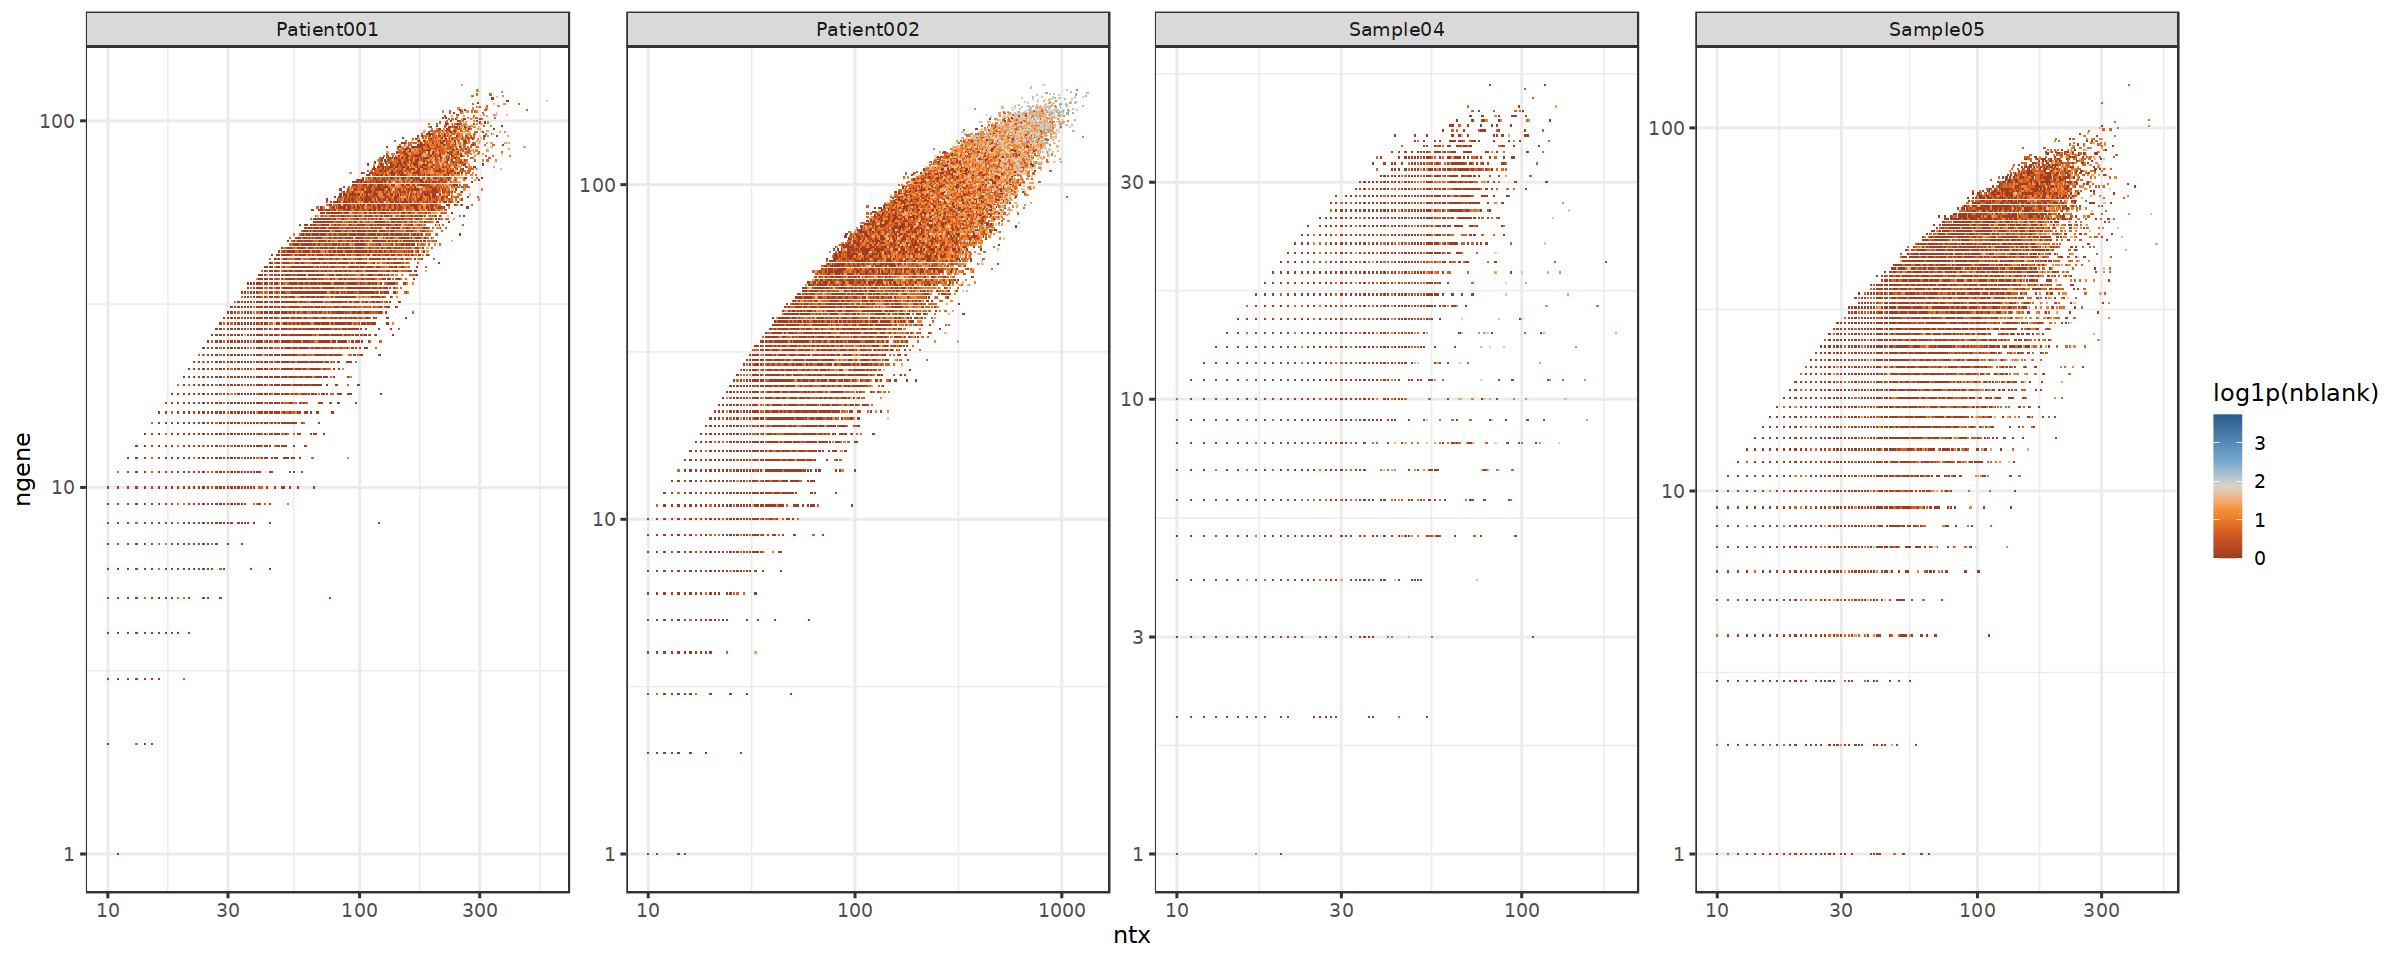

In [48]:
fig.size(8, 20)
meta_data %>% 
    ggplot(aes(ntx, ngene, color = log1p(nblank))) + 
        geom_point(shape = '.') + 
        facet_wrap(~library, scales = 'free', nrow = 1) + 
        theme_bw(base_size = 14) + 
        scale_x_log10() + scale_y_log10() + 
        scale_color_gradient2_tableau() + 
        NULL


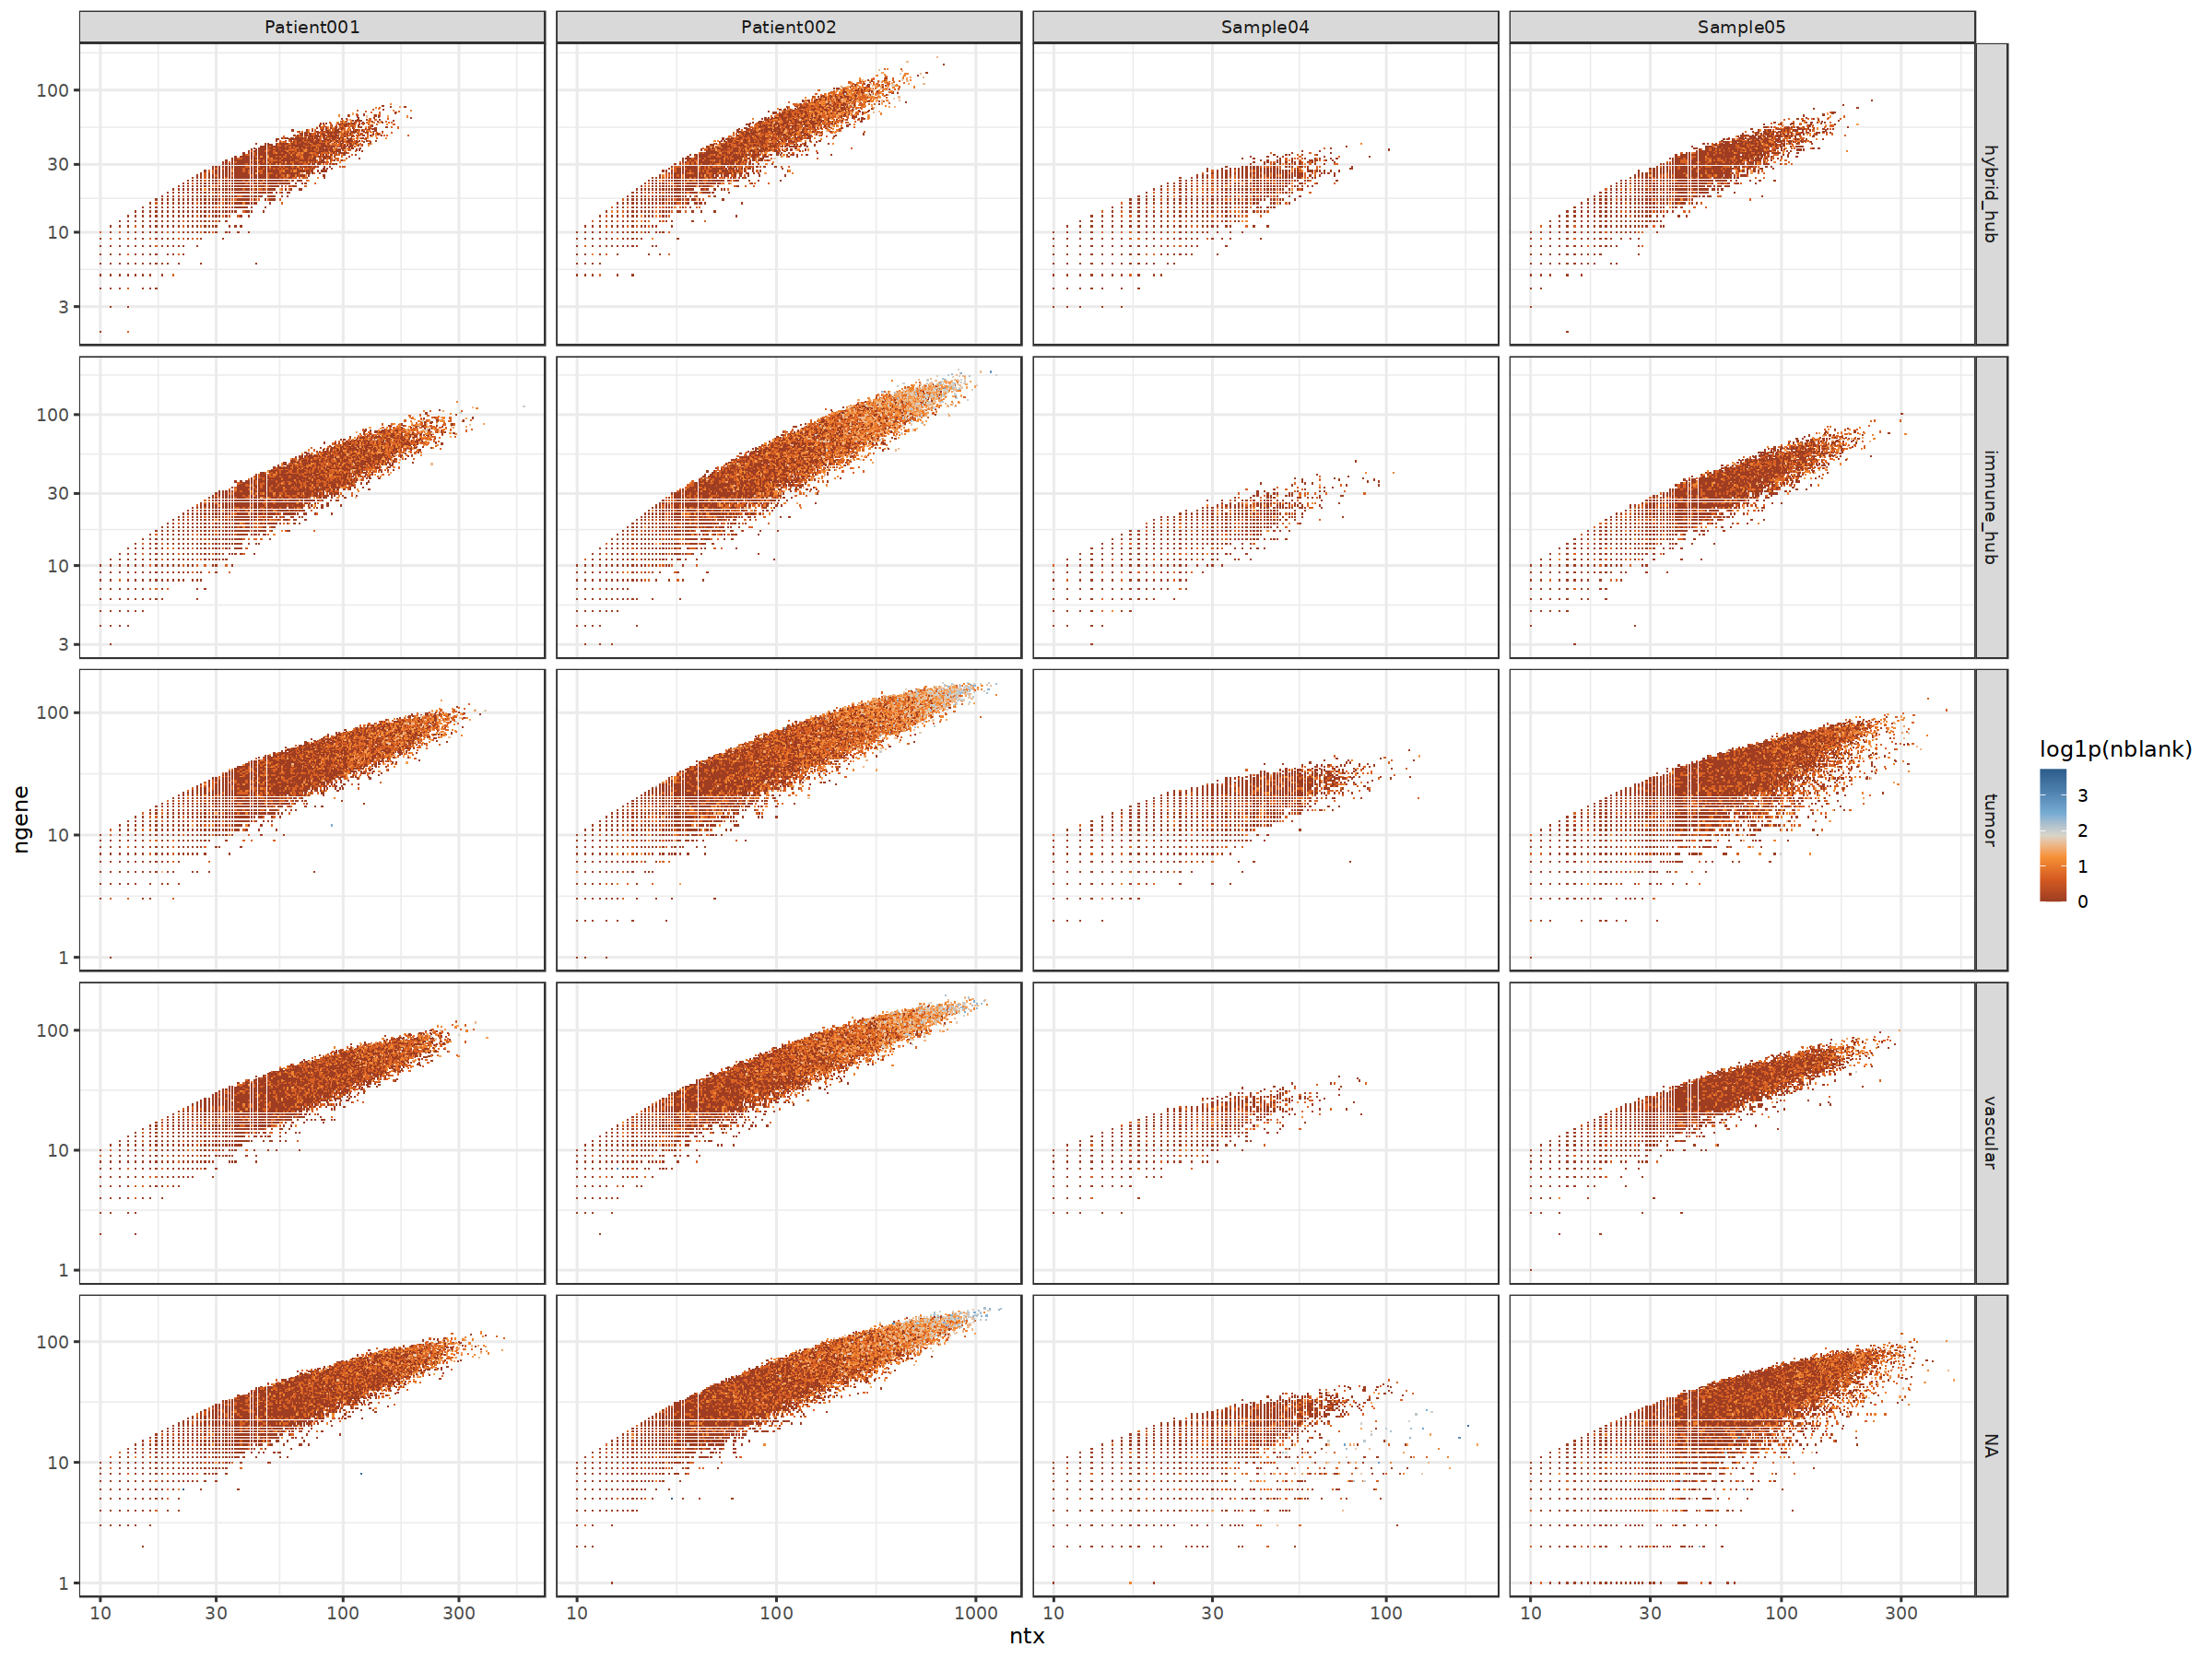

In [50]:
fig.size(15, 20)
meta_data %>% 
    ggplot(aes(ntx, ngene, color = log1p(nblank))) + 
        geom_point(shape = '.') + 
        facet_grid(hubType ~ library, scales = 'free') + 
        theme_bw(base_size = 14) + 
        scale_x_log10() + scale_y_log10() + 
        scale_color_gradient2_tableau() + 
        NULL


In [ ]:
meta_data

## PCA

In [79]:
logcpx <- normalizeData(counts, median(colSums(counts)), 'log')

In [80]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID hubSize_tiles
1 1    Patient001 7086.414  79.414864 30  23    0      R686   66          
2 2    Patient001 7090.282 -74.397942 16  14    0      R490  233          
3 3    Patient001 7087.515 -21.805606 15  12    1      R490  233          
4 4    Patient001 7099.331 -17.703966 29  20    0      R490  233          
5 5    Patient001 7100.477  -9.060024 29  16    1      R490  233          
6 6    Patient001 7093.215  -5.783358 31  22    0      R490  233          
  hubSize_um2 hubType     
1 165000      tumor       
2 542538      immune_other
3 542538      immune_other
4 542538      immune_other
5 542538      immune_other
6 542538      immune_other

In [ ]:
## Option 1: unweighted PCA
# pca_res <- weighted_pca(logcpx, rep(1, ncol(counts)), do_corr = FALSE) 

## Option 2: weight by sample ID
y <- with(meta_data, paste(library, hubType, sep = '_'))
weights <- as.numeric(((1/table(y))[y]) * (length(y)/length(unique(y))))
system.time({
    pca_res <- weighted_pca(logcpx, weights, do_corr = FALSE)     
})


In [ ]:
fig.size(4, 6)
plot(apply(pca_res$embeddings, 2, var))


In [ ]:
system.time({
    ## Standard parameters 
    # U <- uwot::umap(pca_res$embeddings, min_dist = 0.1, spread = 0.3, ret_extra = 'fgraph')    
    
    ## Maxmize white space to highlight doublets 
    U <- uwot::umap(pca_res$embeddings, min_dist = 0.01, spread = 0.22, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)    
})



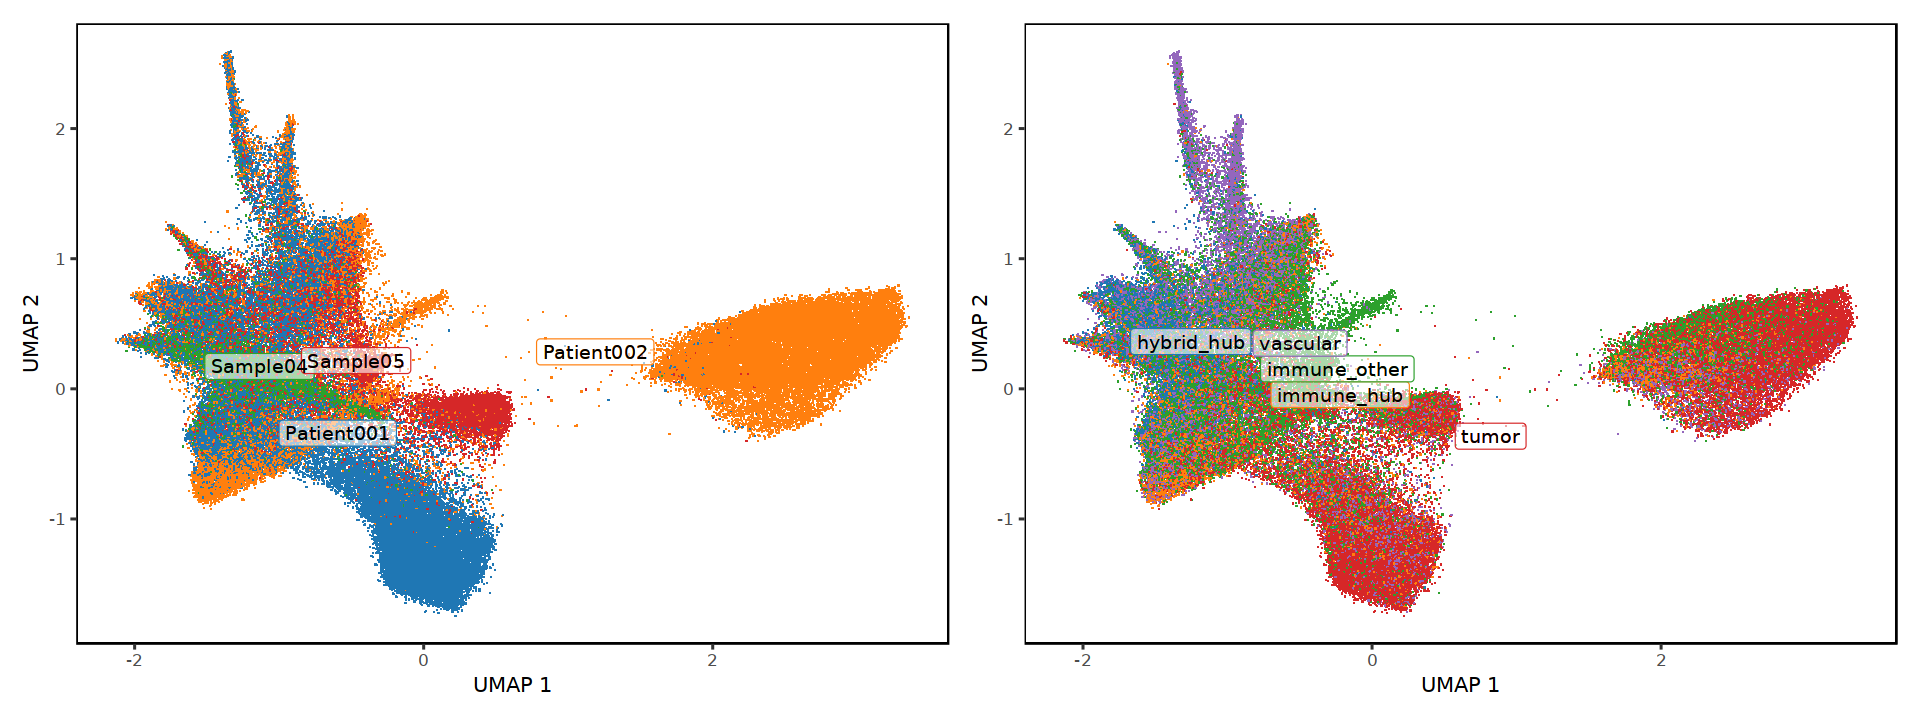

In [17]:
fig.size(6, 16)
i = sample(nrow(meta_data), 1e5)
do_scatter(U$embedding[i, ], meta_data[i, ], 'library', palette_use = tableau_color_pal('Classic 10')(4)) | 
do_scatter(U$embedding[i, ], meta_data[i, ], 'hubType', palette_use = tableau_color_pal('Classic 10')(5))


In [ ]:
# fig.size(8, 12)
# do_scatter(U$embedding, meta_data, 'hubType', palette_use = tableau_color_pal('Classic 10')(3)) + 
#     facet_grid(hubType~library)
#     # facet_wrap(~library, nrow = 2)


## Harmonize


In [ ]:
fig.size(5, 8)
system.time({
    harmony_res <- HarmonyMatrix(
        pca_res$embeddings, 
        meta_data, 'library', theta = .5, 
        do_pca = FALSE,
        # max.iter.harmony = 1, max.iter.cluster = 5, 
        max.iter.harmony = 5, max.iter.cluster = 30, 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, plot_convergence = TRUE, 
        return_object = TRUE
    )    
})


In [ ]:
system.time({
    U2 <- uwot::umap(t(harmony_res$Z_cos), min_dist = 0.01, spread = 0.22, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)    
})


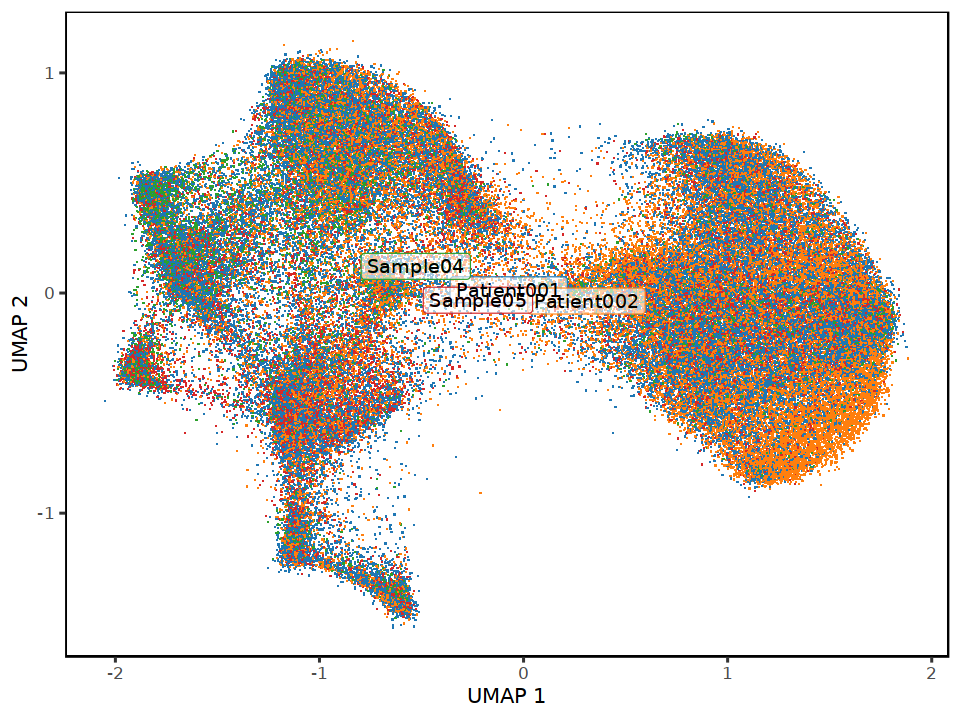

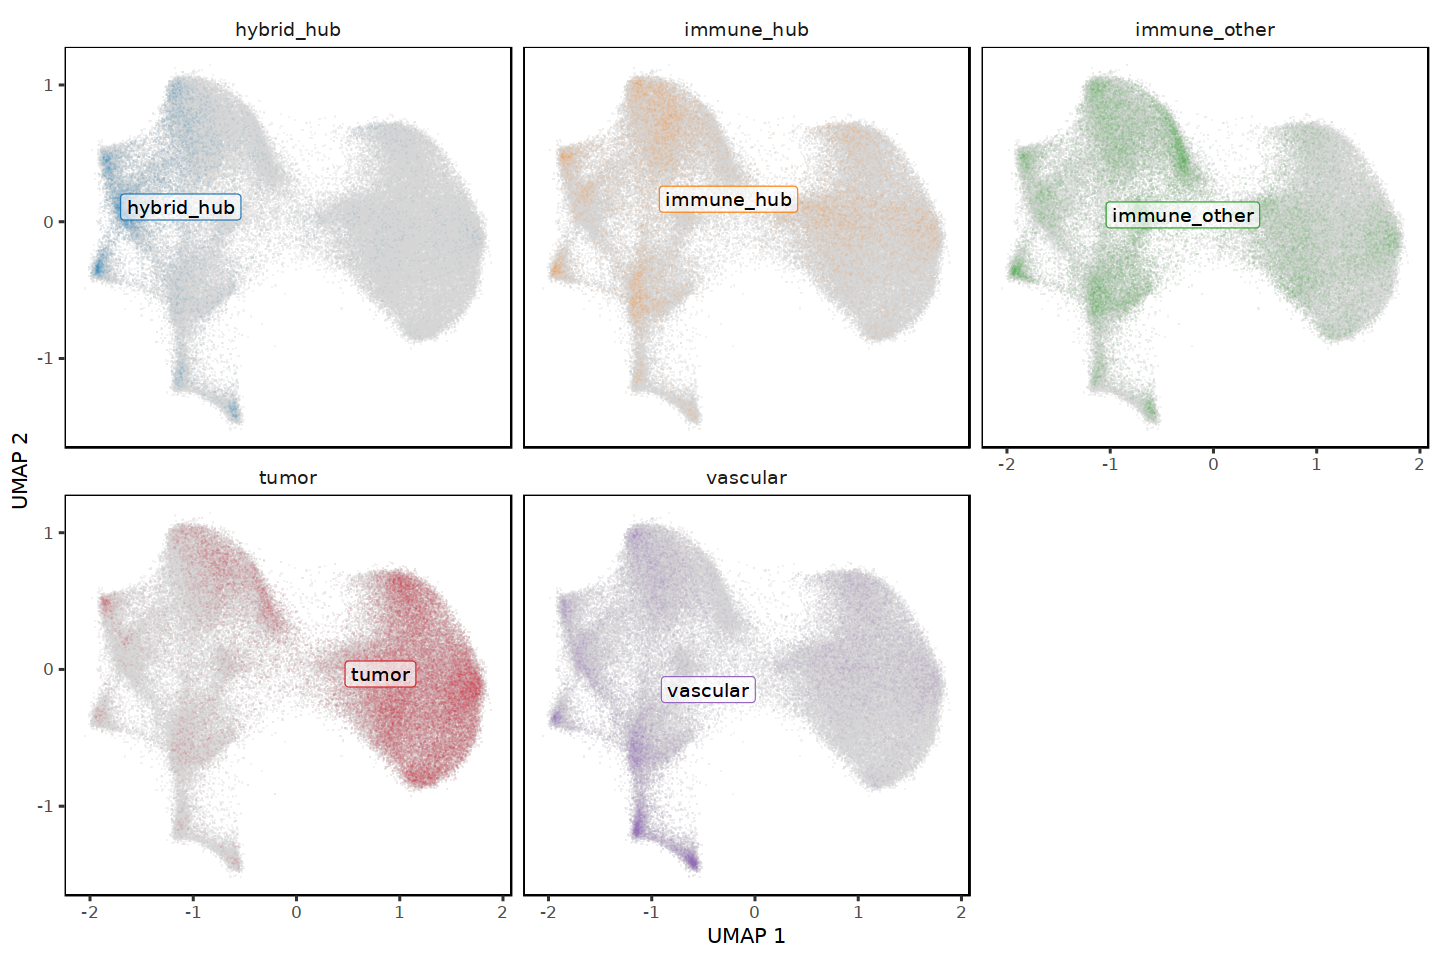

In [21]:
fig.size(6, 8)
i = sample(nrow(meta_data), 1e5)
do_scatter(U2$embedding[i, ], meta_data[i, ], 'library', palette_use = tableau_color_pal('Classic 10')(4))

fig.size(8, 12)
do_scatter(U2$embedding[i, ], meta_data[i, ], 'hubType', quo(hubType), nrow = 2, palette_use = tableau_color_pal('Classic 10')(5), alpha_fore = .05) 



In [14]:
# fig.size(5, 8)
# plot(harmony_res$objective_kmeans)

## Clusters

### Coarse

In [ ]:
plan(multicore)
system.time({
    clusters <- RunModularityClustering(U2$fgraph, resolution = c(.05, .1, .2, .4, .6, .8, 1.2, 1.5, 1.8, 2.1))
    clusters <- map(clusters, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
})


In [27]:
map(map(clusters, table), length)

$Clust0.05
[1] 2

$Clust0.1
[1] 2

$Clust0.2
[1] 4

$Clust0.4
[1] 9

$Clust0.6
[1] 11

$Clust0.8
[1] 15

$Clust1.2
[1] 18

$Clust1.5
[1] 20

$Clust1.8
[1] 24

$Clust2.1
[1] 28

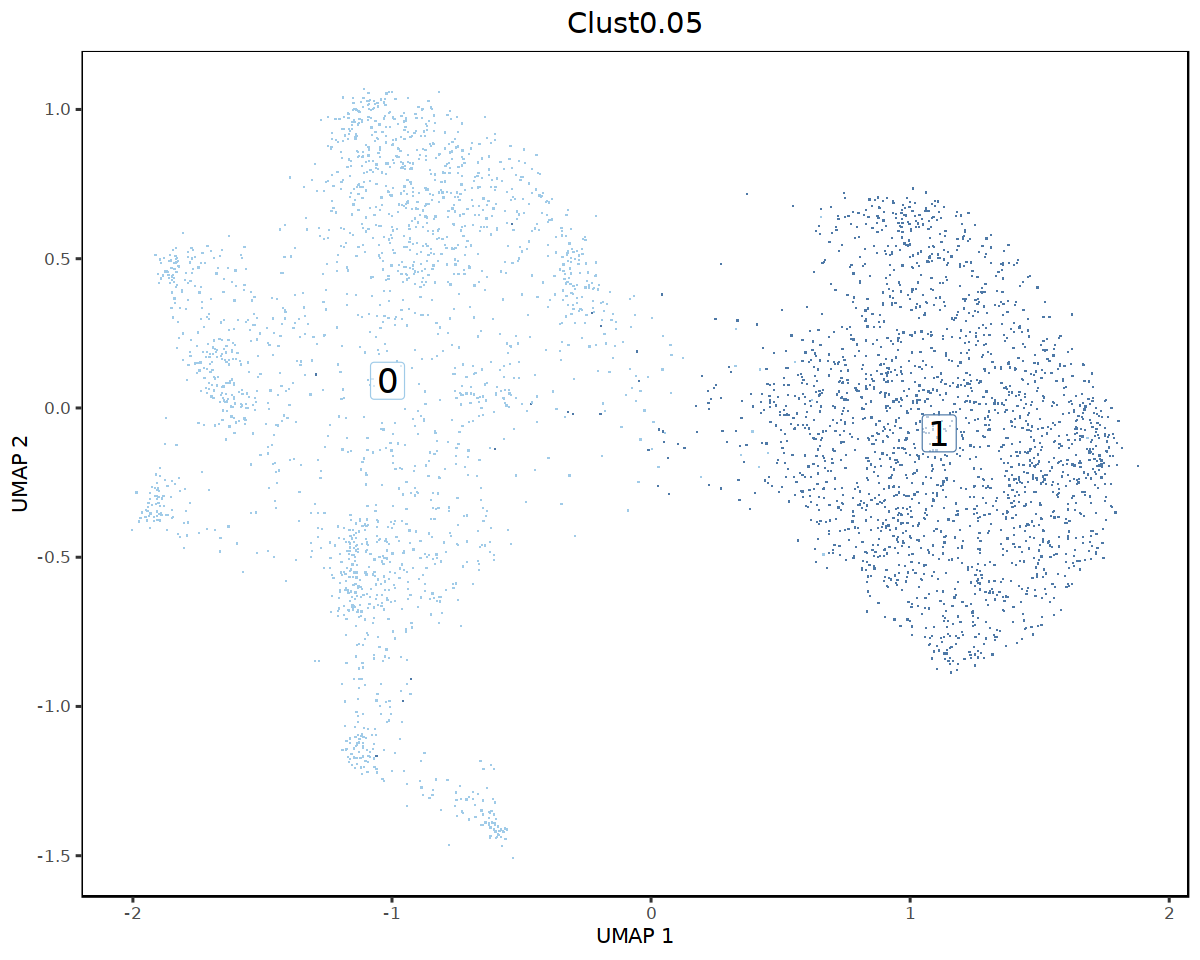

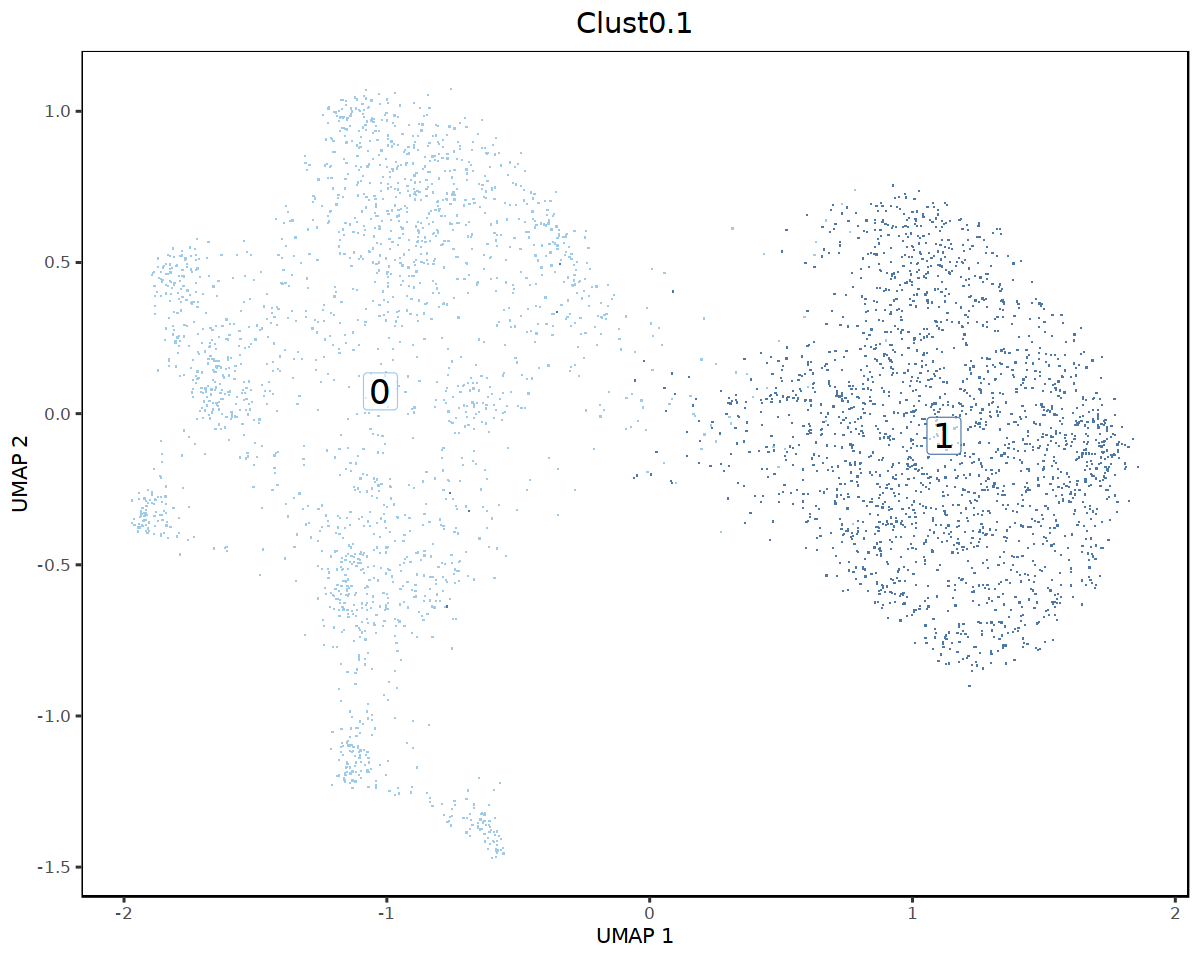

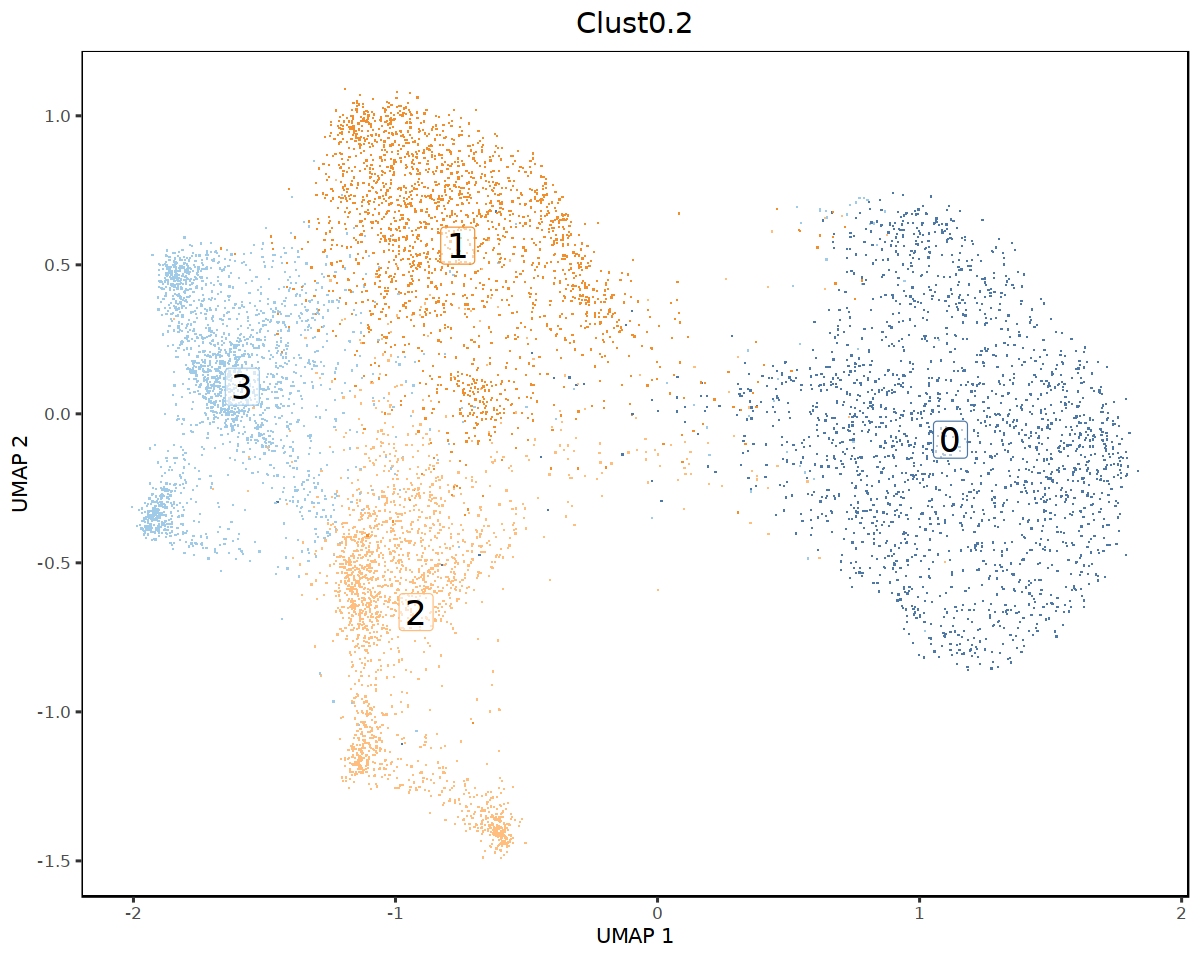

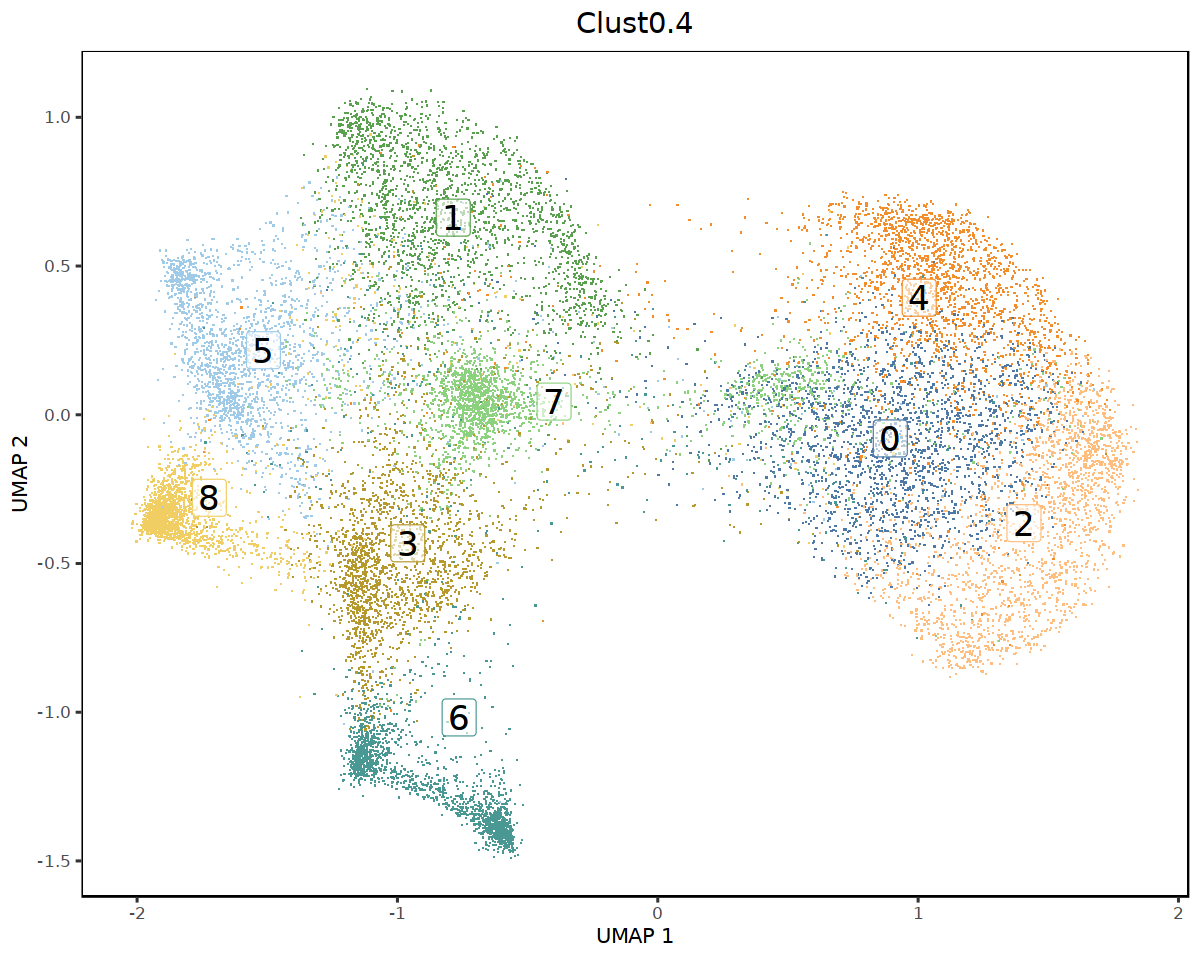

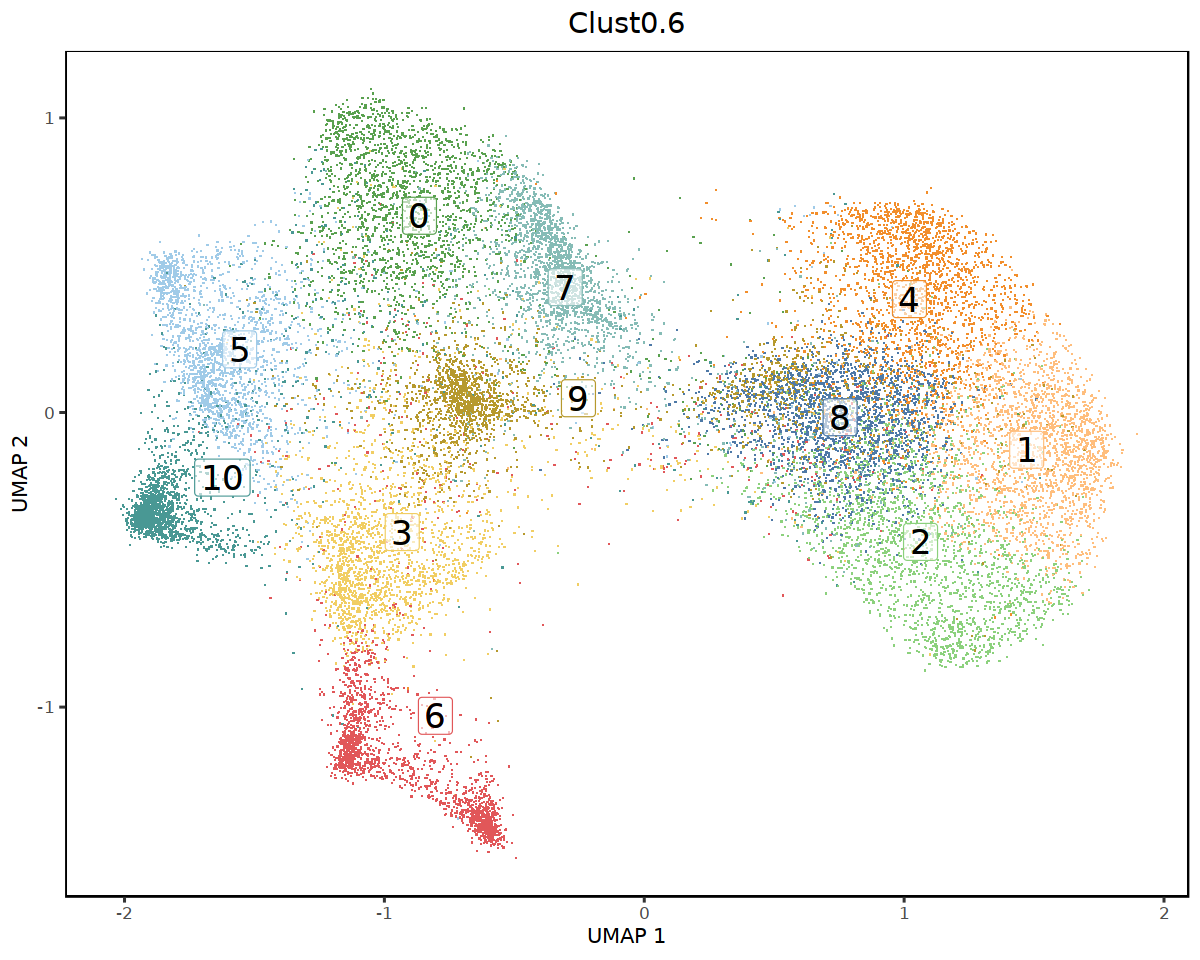

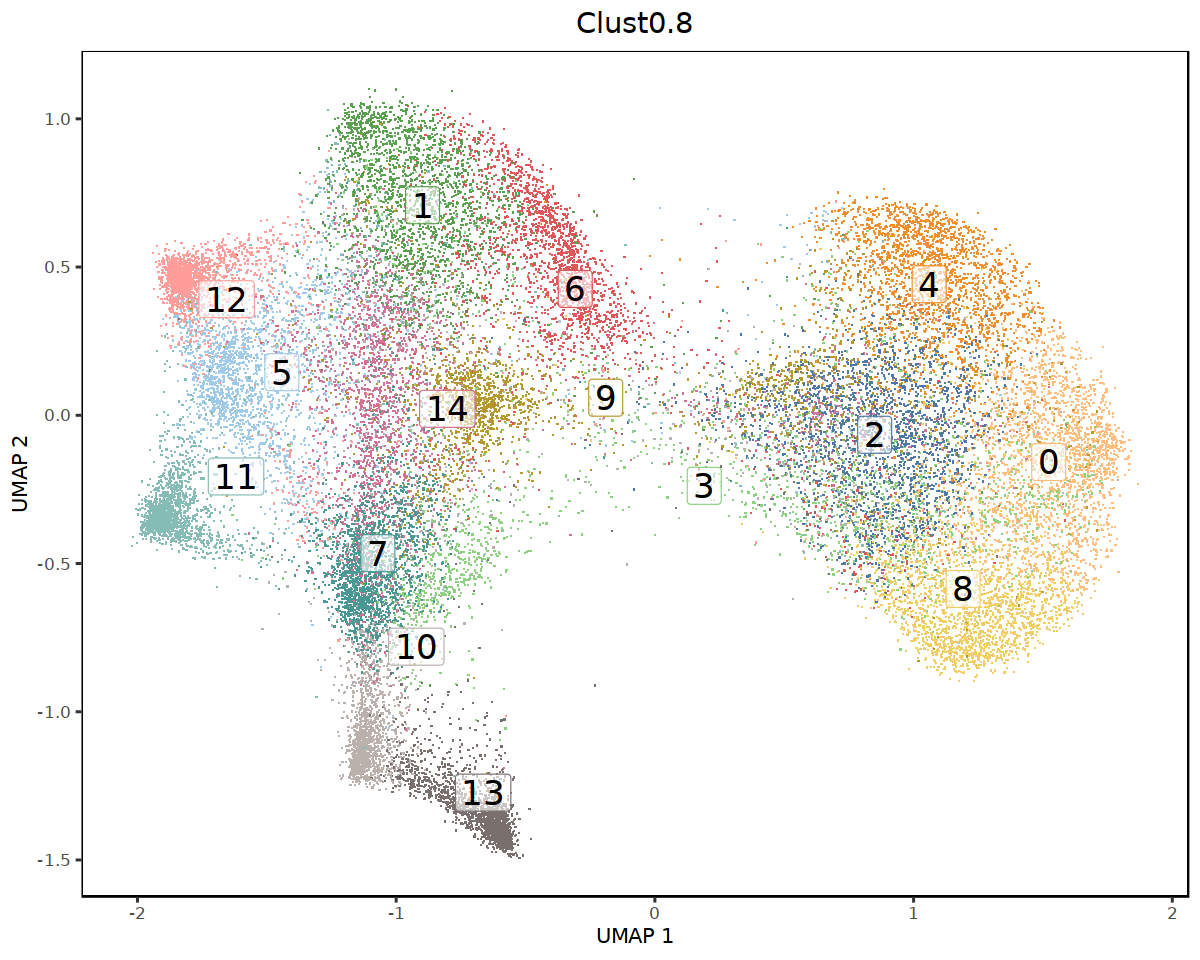

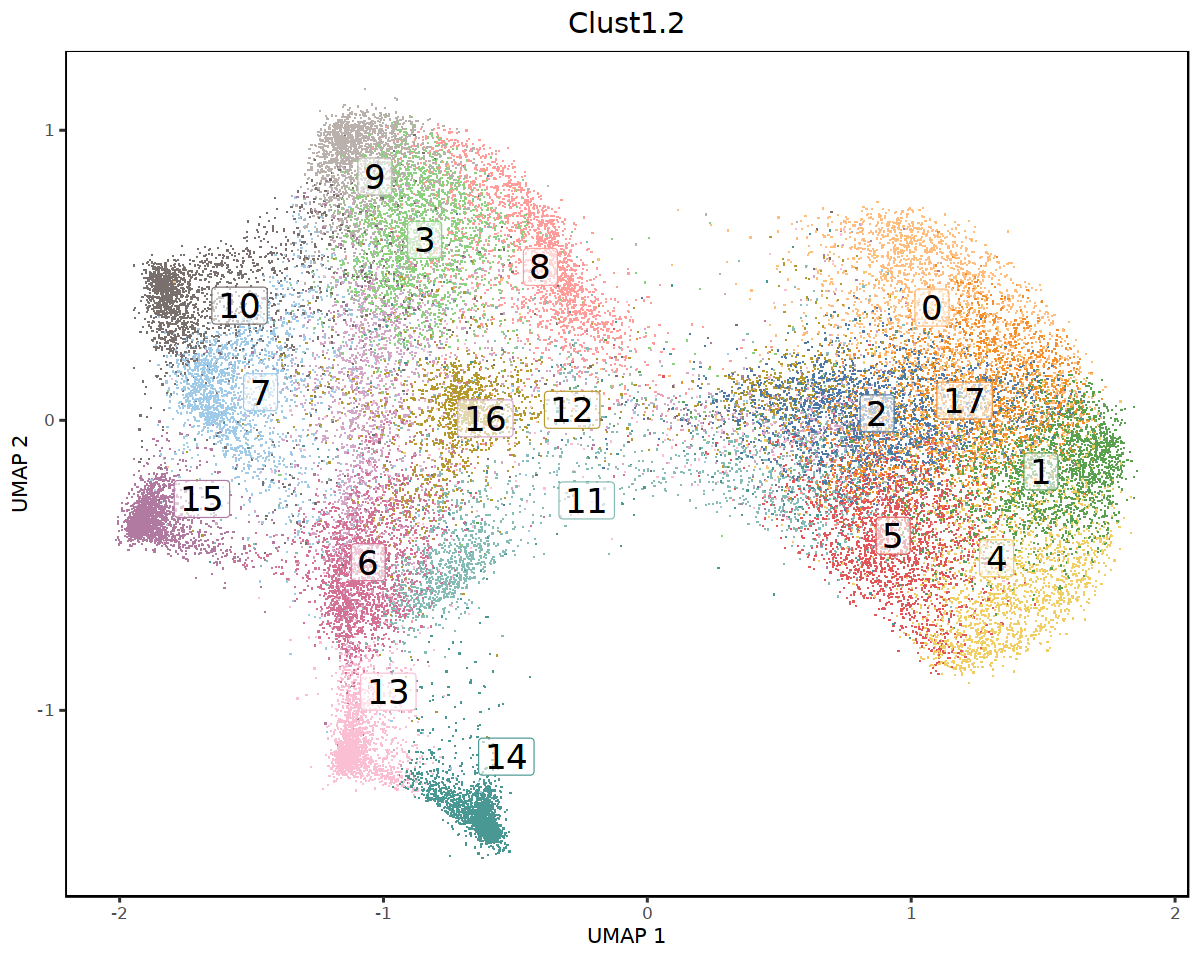

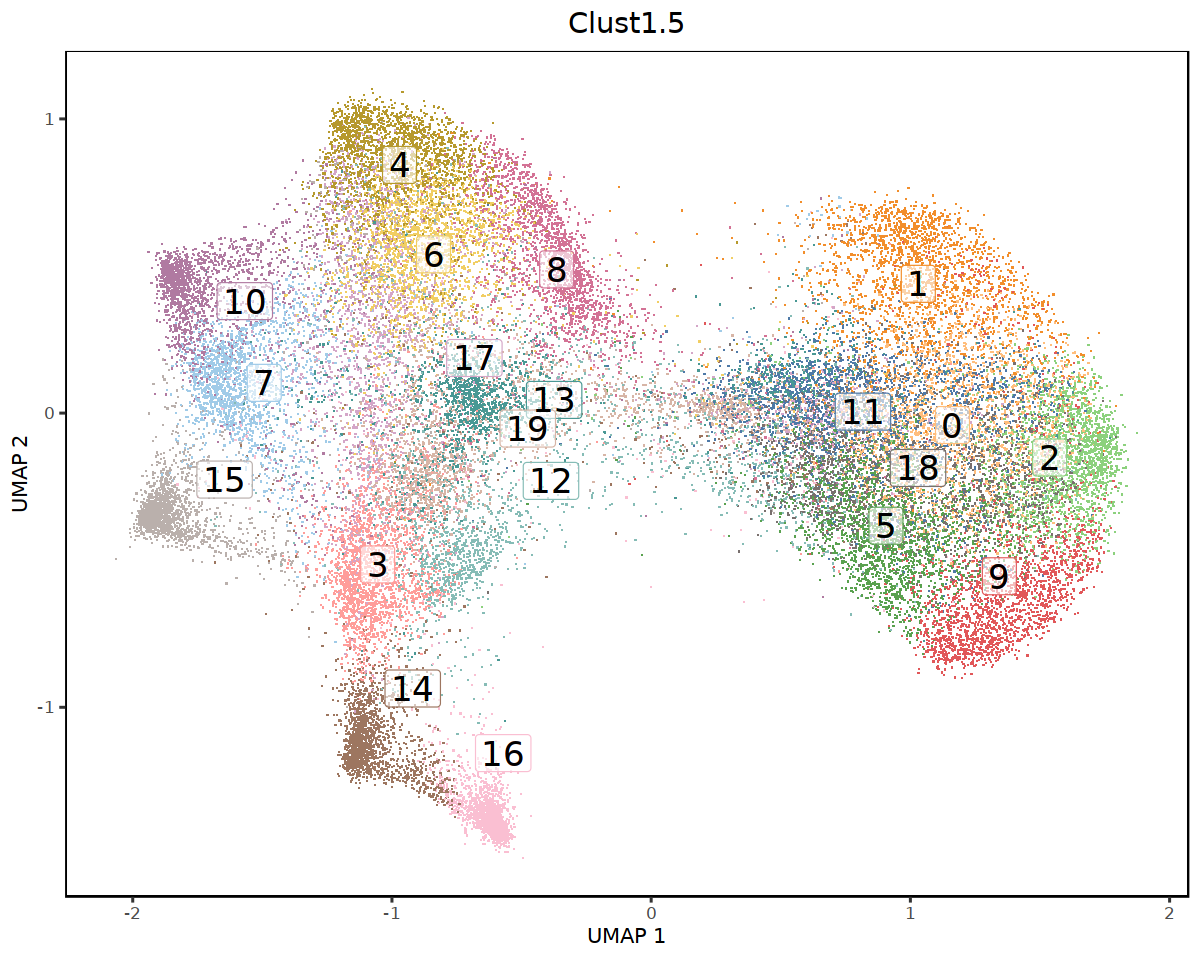

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]


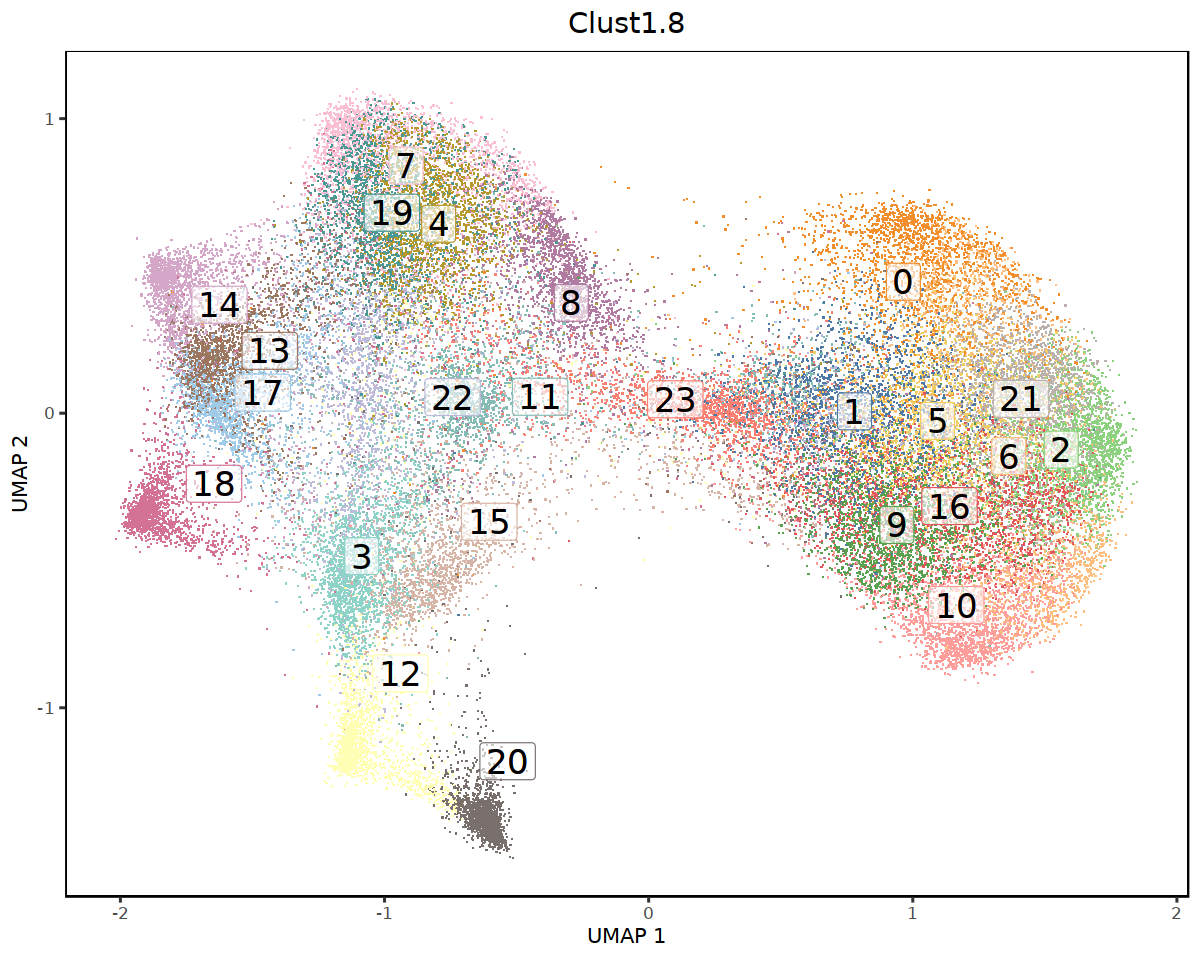

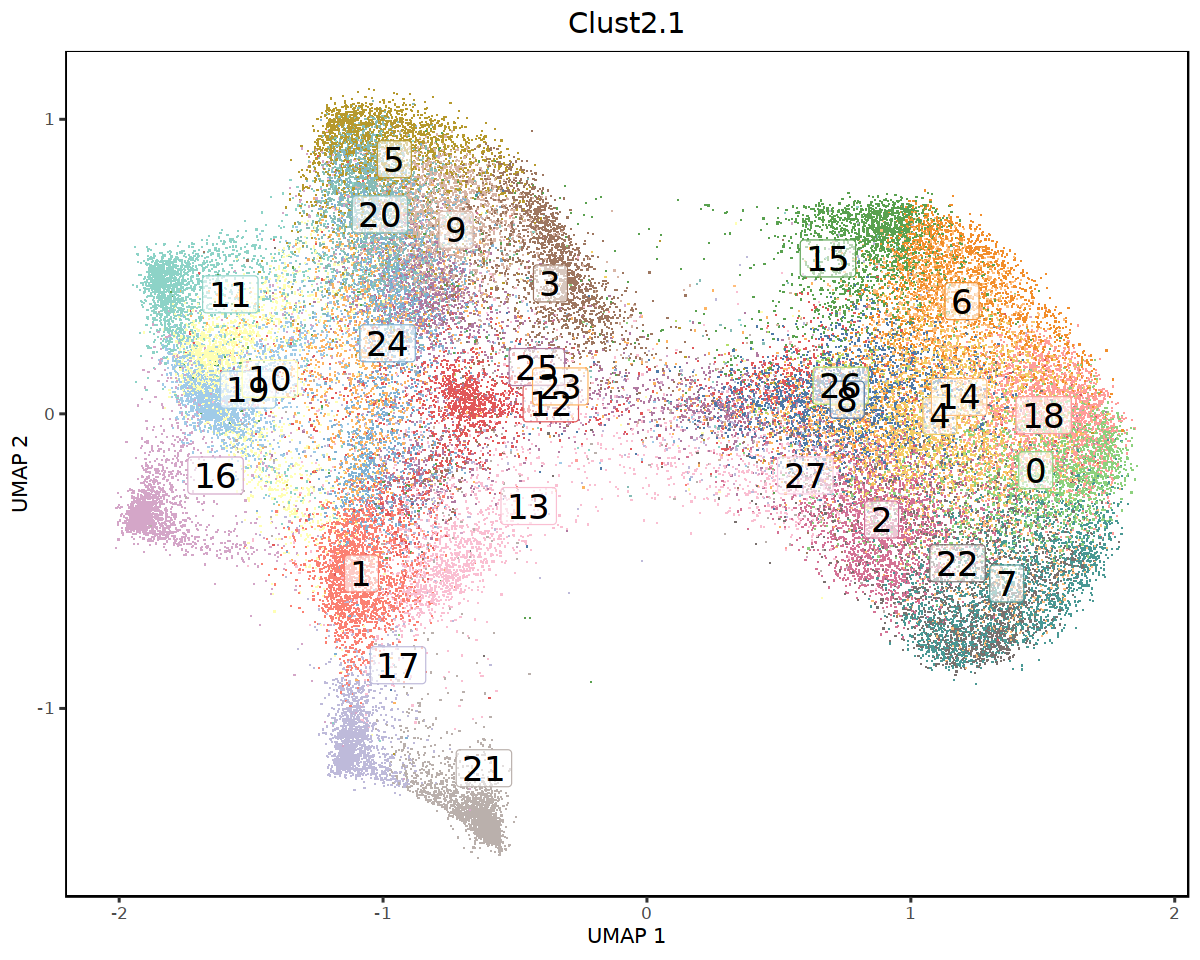

In [73]:
fig.size(8, 10)
map(colnames(clusters), function(name) {
    i = data.table(clusters)[, i := 1:.N][, dplyr::sample_n(.SD, min(2e3, .N)), by = name][, i] 
    do_scatter(U2$embedding[i, ], clusters[i, ], name, pt_size = 7) + labs(title = name) 
})


In [74]:
# fig.size(8, 10)
# i = sample((nrow(clusters)), 1e5)
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', pt_size = 7) + labs(title = 'Clust2.1') 
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', pt_size = 7) + labs(title = 'Clust2.1') 
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', pt_size = 7) + labs(title = 'Clust2.1') 
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', pt_size = 7) + labs(title = 'Clust2.1') 
# # do_scatter(U2$embedding, clusters, 'Clust2.1') 


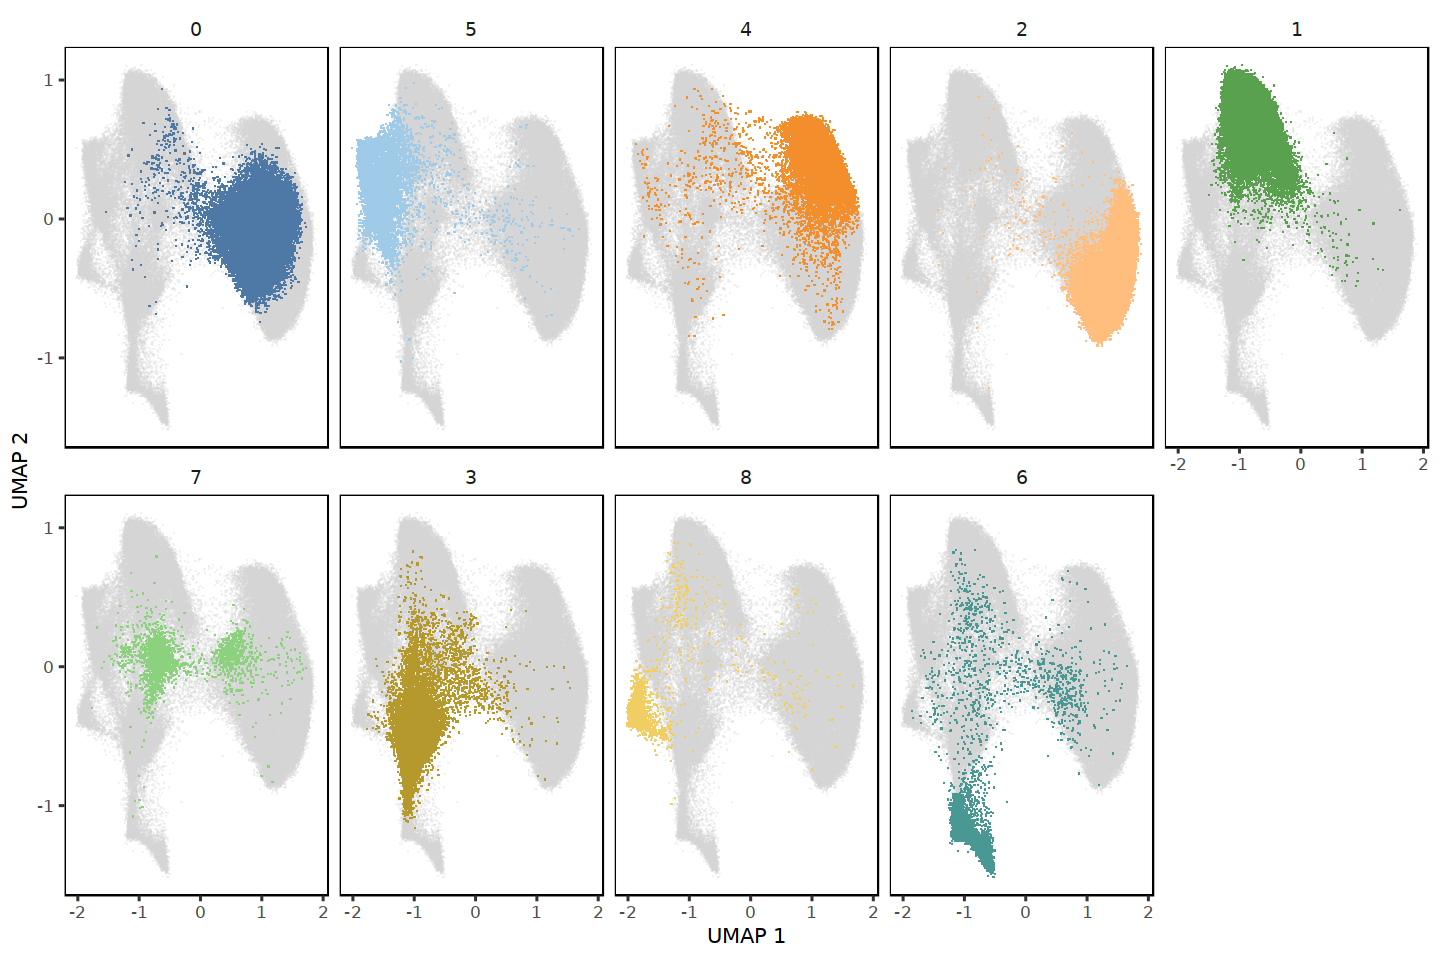

In [84]:
fig.size(8, 12)
i = sample((nrow(clusters)), 1e5)
do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust0.4', quo(Clust0.4), nrow = 2, do_labels = FALSE) 
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust0.2', quo(Clust0.2), nrow = 2, do_labels = FALSE) 

# fig.size(20, 20)
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', quo(Clust2.1), nrow = 5, do_labels = FALSE) 
# do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', quo(Clust2.1), nrow = 5, do_labels = FALSE) 


In [8]:
meta_data$type_lvl1 <- case_when(
    clusters$`Clust0.4` %in% c('0', '4', '2') ~ 'Epithelial',
    clusters$`Clust0.4` %in% c('1') ~ 'Myeloid',
    clusters$`Clust0.4` %in% c('8') ~ 'Plasma',
    clusters$`Clust0.4` %in% c('7') ~ 'Mast_Epi',
    clusters$`Clust0.4` %in% c('5') ~ 'Lymphocyte',
    clusters$`Clust0.4` %in% c('6') ~ 'Vascular',
    clusters$`Clust0.4` %in% c('3') ~ 'Fibroblast'
) 


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


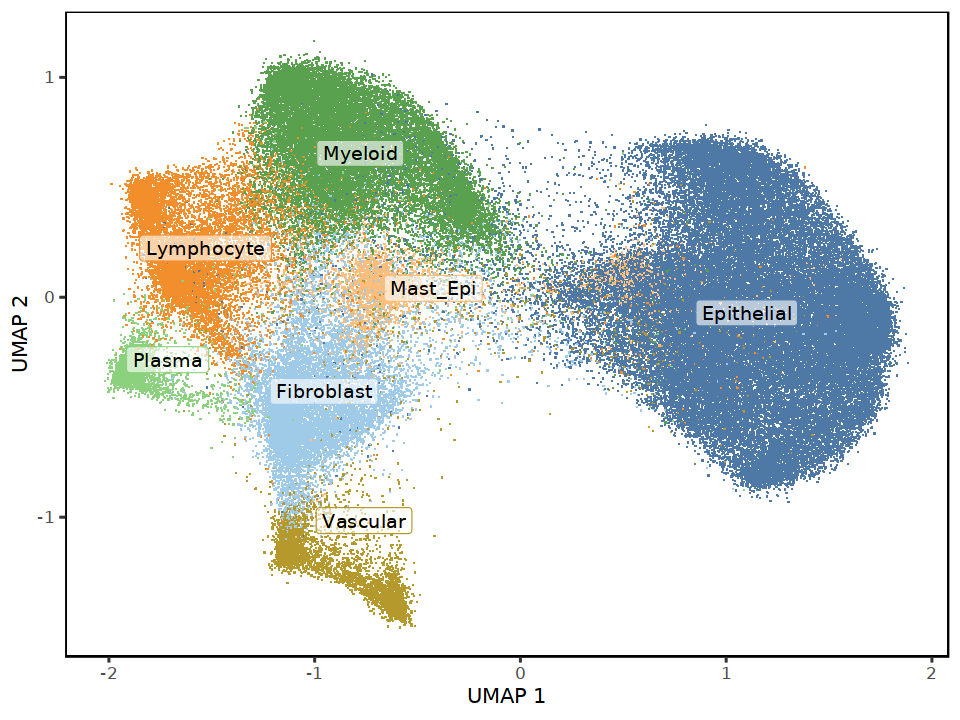

In [9]:
fig.size(6, 8)
i = sample((nrow(clusters)), 1e5)
do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl1', do_labels = TRUE) 


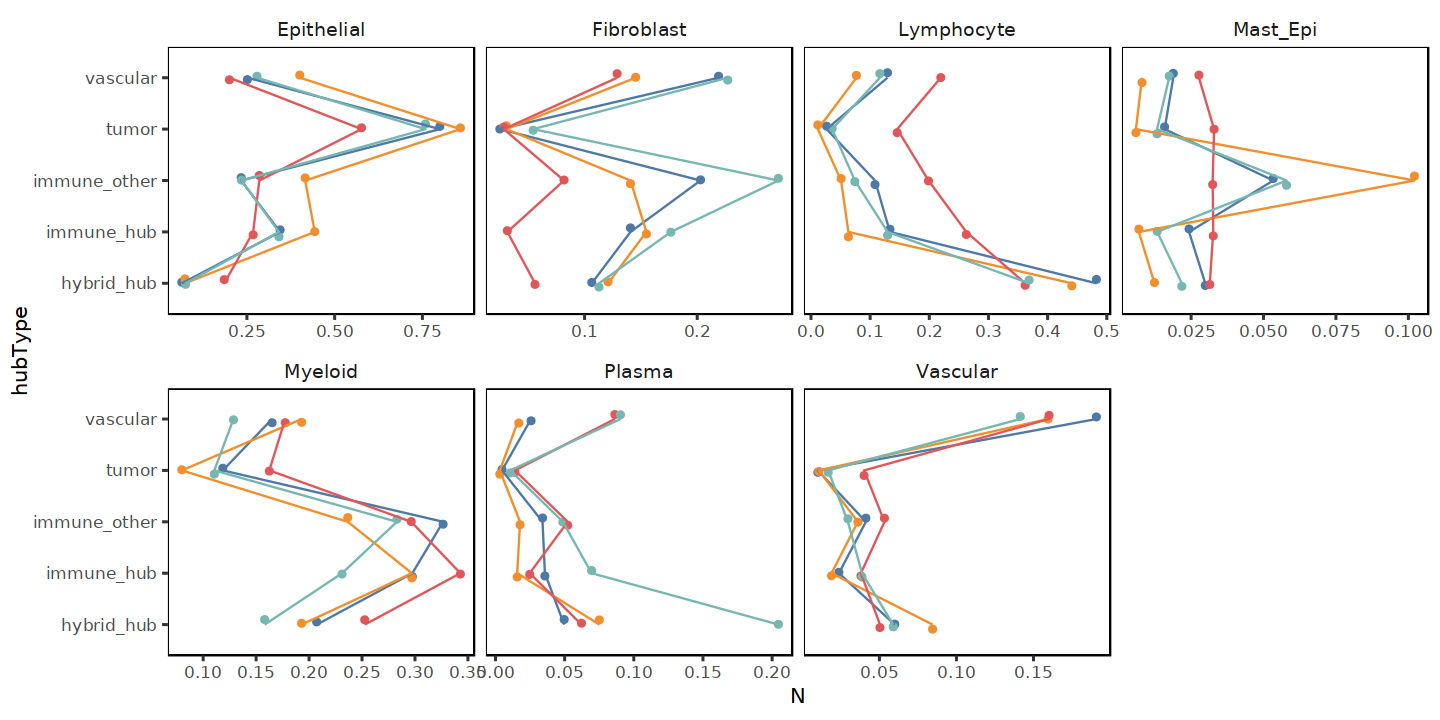

In [22]:
fig.size(6, 12)
meta_data %>% 
    with(table(paste(library, hubType), type_lvl1)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    tidyr::separate(V2, c('library', 'hubType'), ' ') %>% 
    ggplot(aes(hubType, N, color = library)) +
        geom_jitter(height = 0, width = .1) + 
        geom_line(aes(group = library)) + 
        facet_wrap(~type_lvl1, scales = 'free_x', nrow = 2) + 
        scale_color_tableau() + 
        coord_flip() + 
        guides(color = 'none') + 
        NULL


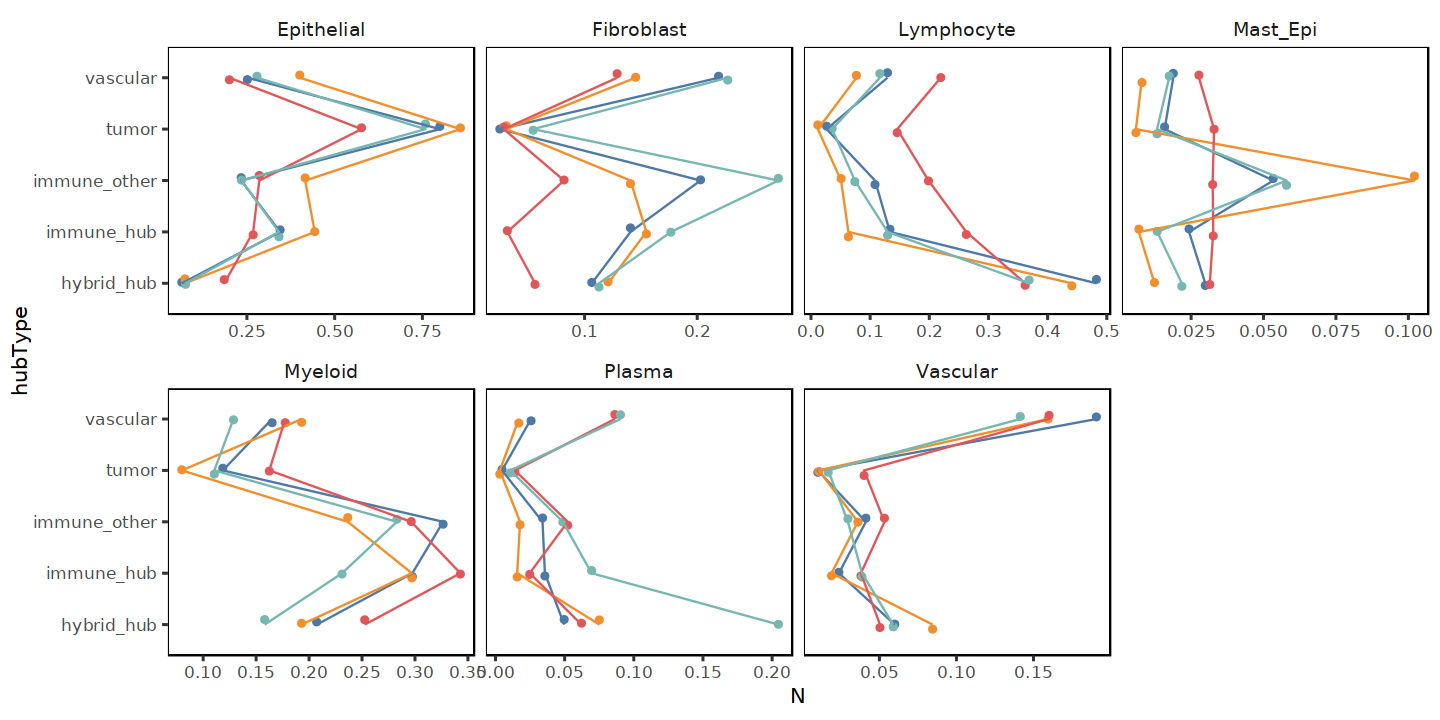

In [22]:
fig.size(6, 12)
meta_data %>% 
    with(table(paste(library, hubType), type_lvl1)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    tidyr::separate(V2, c('library', 'hubType'), ' ') %>% 
    ggplot(aes(hubType, N, color = library)) +
        geom_jitter(height = 0, width = .1) + 
        geom_line(aes(group = library)) + 
        facet_wrap(~type_lvl1, scales = 'free_x', nrow = 2) + 
        scale_color_tableau() + 
        coord_flip() + 
        guides(color = 'none') + 
        NULL


### Mast

Subcluster into 2

In [11]:
source('../Clustering/cluster_utils.R')

In [23]:
i = which(grepl('mast', meta_data$type_lvl1, ignore.case = TRUE))
length(i)

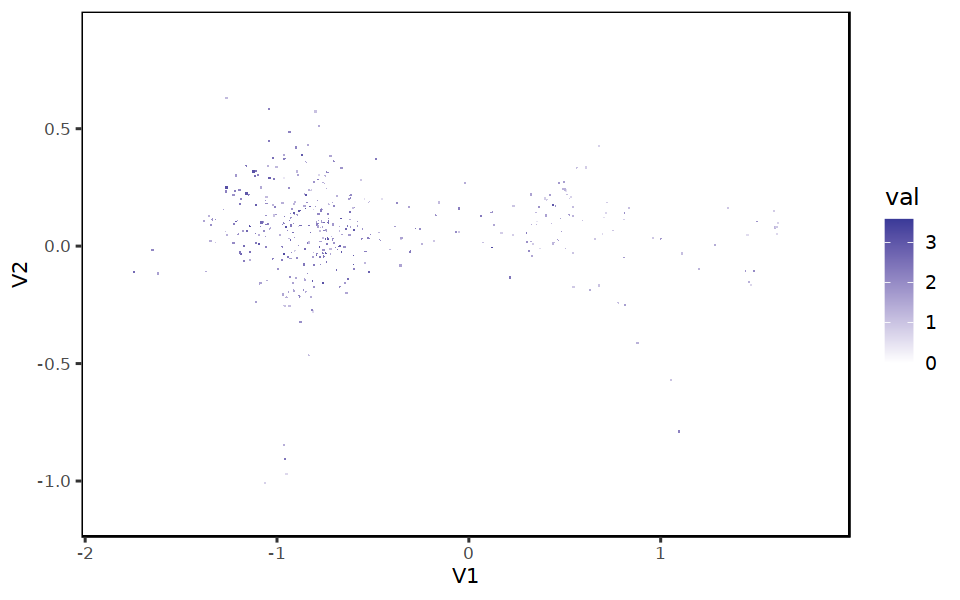

In [34]:
U2$embedding[i, ] %>% 
    cbind(meta_data[i, ]) %>% 
    cbind(val = normalizeData(counts[, i], 100, "log")['CPA3', ]) %>% 
    ggplot(aes(V1, V2, color = val)) + 
        geom_point(shape = '.') + 
        scale_color_gradient2(midpoint = 0) + 
        NULL


In [45]:
.c = split_clusters(meta_data$type_lvl1, 'Mast_Epi', U2$fgraph, .2, 10, 2, min_size = 50)

Warning message in order(as.integer(gsub("^(.*)_.*$", "\\1", cluster_levels))):
“NAs introduced by coercion”


In [46]:
table(.c)

.c
Epithelial Fibroblast Lymphocyte Mast_Epi_1 Mast_Epi_2    Myeloid     Plasma 
    756179     186554     166657      35671      10556     303126      44010 
  Vascular 
     88588 

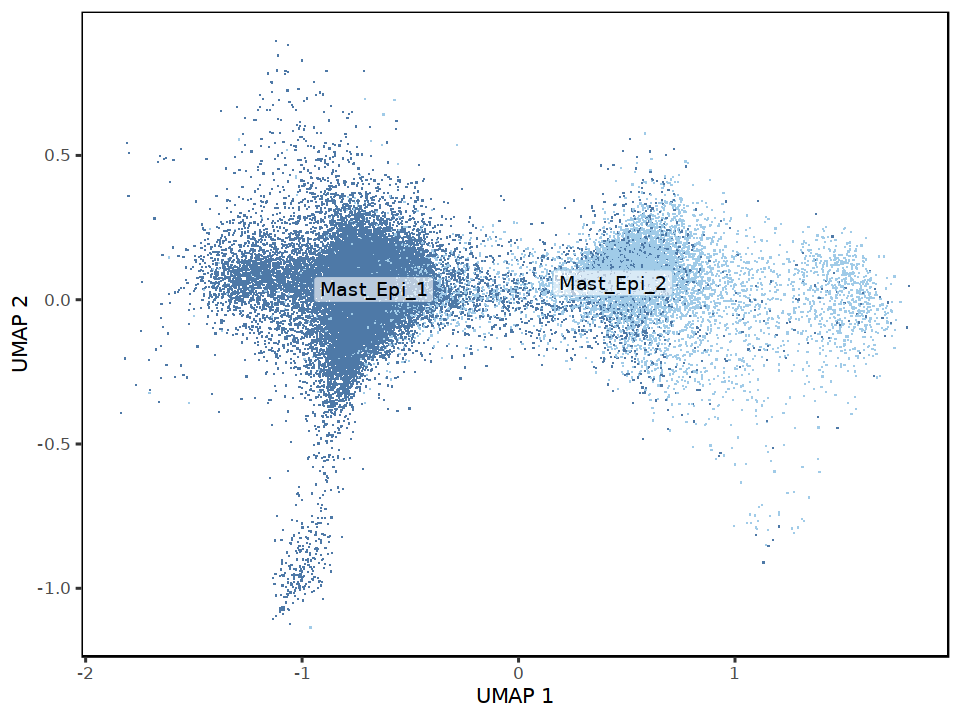

In [47]:
fig.size(6, 8)
do_scatter(U2$embedding[i, ], tibble(CLUSTER = .c[i]), 'CLUSTER')
# do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl1')


In [53]:
meta_data$type_lvl1 = case_when(
    .c == 'Mast_Epi_1' ~ 'Mast',
    .c == 'Mast_Epi_2' ~ 'Epithelial',
    TRUE ~ as.character(.c)
)

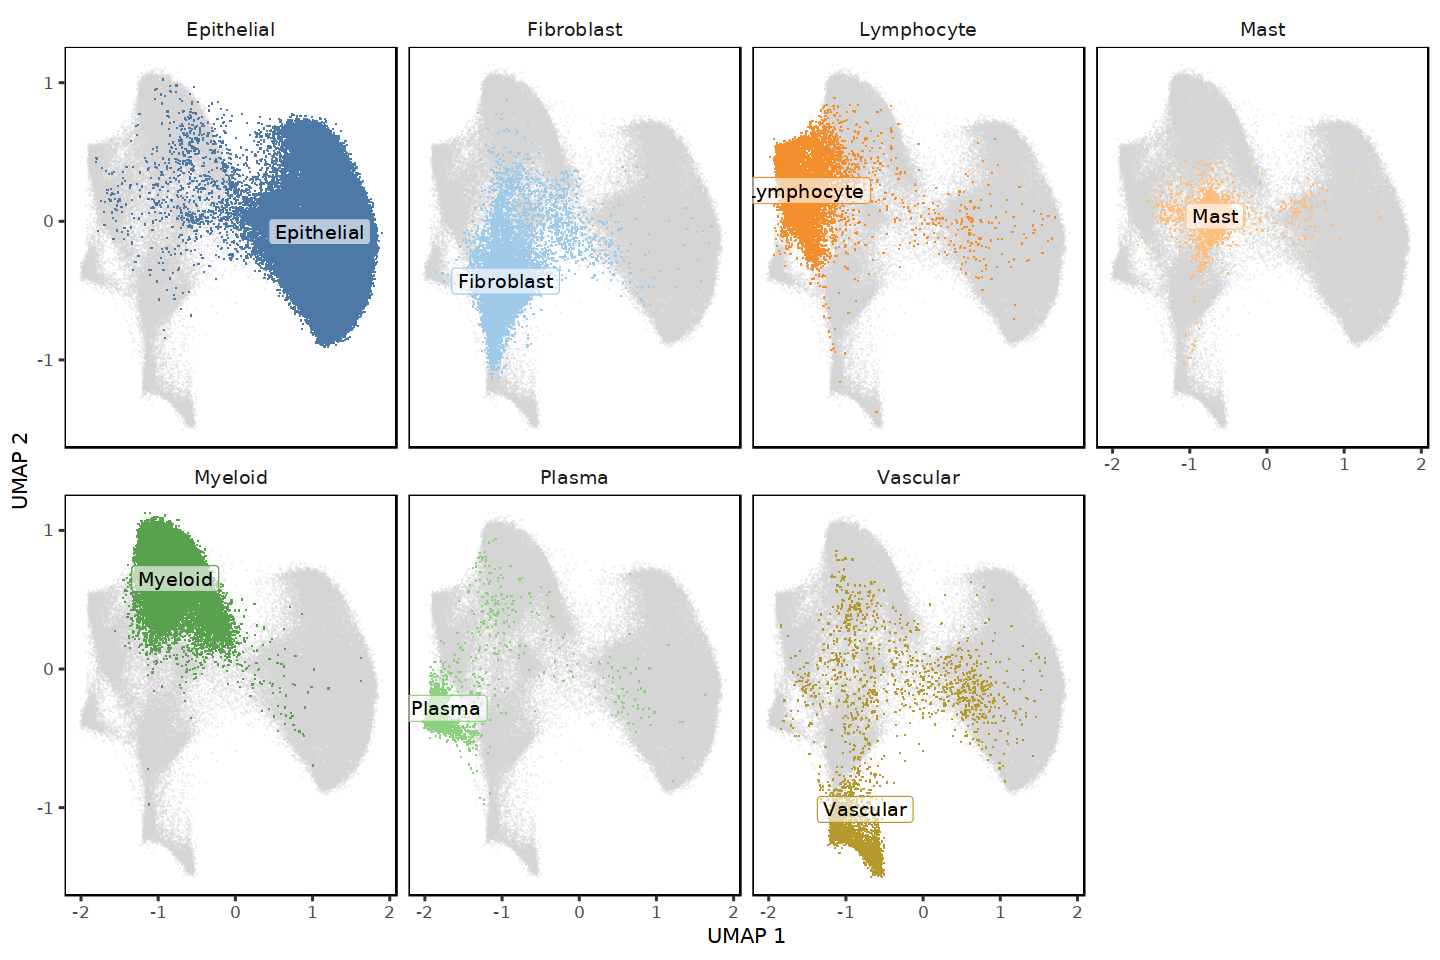

In [56]:
fig.size(8, 12)
i = sample((nrow(clusters)), 1e5)
do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl1', quo(type_lvl1), nrow = 2, do_labels = TRUE) 


### Mast (again)

In [209]:
source('../Clustering/cluster_utils.R')

In [210]:
i = which(grepl('mast', meta_data$type_lvl1, ignore.case = TRUE))
length(i)

[1] 35671

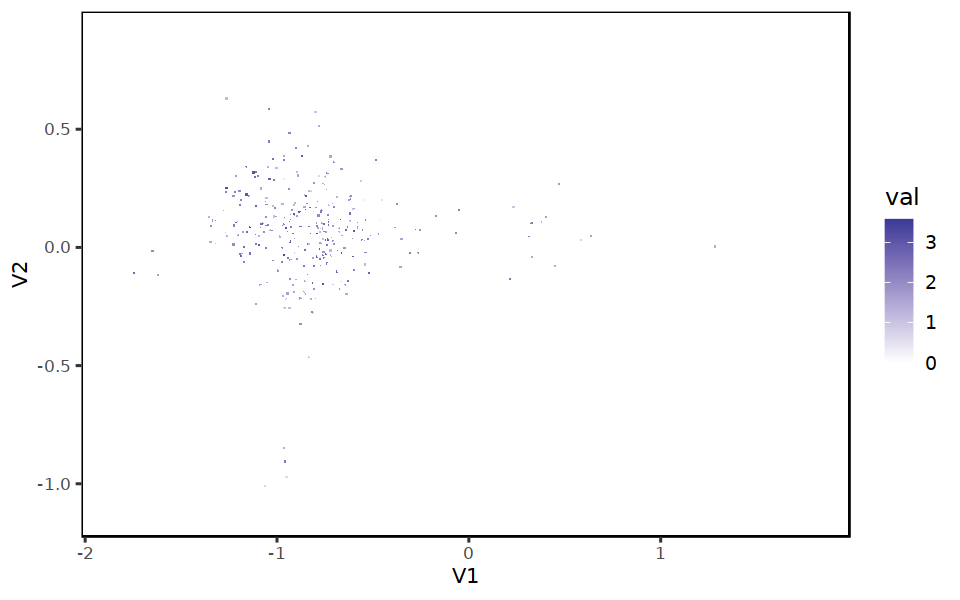

In [214]:
fig.size(5, 8)
U2$embedding[i, ] %>% 
    cbind(meta_data[i, ]) %>% 
    cbind(val = normalizeData(counts[, i], 100, "log")['CPA3', ]) %>% 
    ggplot(aes(V1, V2, color = val)) + 
        geom_point(shape = '.') + 
        scale_color_gradient2(midpoint = 0) + 
        NULL


In [226]:
.c = split_clusters(meta_data$type_lvl1, 'Mast', U2$fgraph, .6, 10, 2, min_size = 50)



Warning message in order(as.integer(gsub("^(.*)_.*$", "\\1", cluster_levels))):
“NAs introduced by coercion”


In [227]:
table(.c)

.c
Epithelial Fibroblast Lymphocyte     Mast_1     Mast_2     Mast_3     Mast_4 
    766743     186554     123664       9087       6787       5072       4072 
    Mast_5     Mast_6     Mast_7     Mast_8     Mast_9    Myeloid     Plasma 
      3520       2606       2580       1627        312     274239      44010 
  Vascular 
     88588 

In [228]:
markers_mast = get_markers(counts, cbind(meta_data, CLUSTER = .c), 'CLUSTER')

CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining, by = "grpvar_orig"


In [229]:
tt(markers_mast)

Warning message in tt(markers_mast):
“NAs introduced by coercion”


[,1]  [,2]     [,3]   [,4]   [,5]     [,6]   [,7]    [,8]   
Epithelial KRT8  TM4SF1   MKI67  ETV4   LAMB3    MET    OSMR    LCN2   
Fibroblast VCAN  COL10A1  COL1A2 PDGFRB SERPINE1 SFRP2  MMP2    FN1    
Lymphocyte FOXP3 ITGAE    GNLY   CD247  ZNF683   CTLA4  TRAC    GZMA   
Mast_1     PSMB8 TNFSF13B MS4A2  NOX4   CCL11    IL17A  PDGFRA  GREM1  
Mast_2     CA1   PDCD1    CTSG   CD69   FCGR3A   APOE   FLI1    S100A12
Mast_3     CPA3  CD69     KIT    CA1    S100A9   MS4A2  SIGLEC6 CCR7   
Mast_4     AZGP1 LAMB3    CX3CL1 LCN2   LY6E     JAG2   MET     EREG   
Mast_5     ESM1  FLI1     CPA3   CCL14  CA1      B3GAT1 DLL4    CCR3   
Mast_6     CTLA4 FOXP3    CCR8   CCR4   TRAC     CD247  CD3D    CD2    
Mast_7     CCL20 PDCD1    FZD1   ESM1   SPP1     S100A9 CMTM2   JAG2   
Mast_8     NR2F2 S1PR3    RGS5   CSPG4  NDUFA4L2 PDGFRB JAG1    COL4A1 
Mast_9     TOP2A MKI67    PTTG1  CDCA7  HMGB2    ADGRG6 CSF3R   TRDC   
Myeloid    MARCO SPP1     MSR1   CD163  ITGAX    C1QC   ALOX5   C1QB   
Plasma     MZB1  CD79A    XBP1   PRDM1  ISG20    CD19   CD27    CD38   
Vascular   VWF   RGS5     S1PR3  NOTCH4 COL4A1   KDR    PDGFRB  CSPG4  
           [,9]     [,10]  
Epithelial VEGFA    SPRY4  
Fibroblast COL3A1   PDPN   
Lymphocyte IL2RB    CD2    
Mast_1     FZD1     TGFBR3 
Mast_2     LYZ      CSF3R  
Mast_3     CTSG     CCR4   
Mast_4     CKB      EFNB2  
Mast_5     BEST4    XCR1   
Mast_6     TNFRSF1B TNFRSF9
Mast_7     B3GAT1   DLL4   
Mast_8     NOTCH3   TGFB3  
Mast_9     XCR1     CLCA1  
Myeloid    LST1     IL2RA  
Plasma     CXCR4    GAS6   
Vascular   GJA4     NOTCH3

In [231]:
.c = as.character(.c)
.c[.c == 'Mast_3'] = 'Mast'
.c[.c %in% paste0('Mast_', c(1:2, 4:9))] = NA

In [233]:
table(.c)

.c
Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma   Vascular 
    766743     186554     123664       5072     274239      44010      88588 

In [234]:
meta_data$type_lvl1 = .c
meta_data$type_lvl1 = factor(meta_data$type_lvl1)

### Myeloid & Lymphoid

Done is separate notebook


In [146]:
meta_data_immune <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells_immune/meta_data.csv')
meta_data_immune$cell = as.character(meta_data_immune$cell)
meta_data_immune$label[which(meta_data_immune$label == '')] = NA

In [147]:
meta_data[, type_lvl2 := NULL]
meta_data[, type_lvl3 := NULL]


Warning message in `[.data.table`(meta_data, , `:=`(type_lvl3, NULL)):
“Column 'type_lvl3' does not exist to remove”


In [148]:
meta_data[
    meta_data_immune[, .(cell, type_lvl2 = label)], 
    on = 'cell',
    type_lvl2 := i.type_lvl2
]

In [149]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID hubSize_tiles
1 1    Patient001 7086.414  79.414864 30  23    0      R686   66          
2 2    Patient001 7090.282 -74.397942 16  14    0      R490  233          
3 3    Patient001 7087.515 -21.805606 15  12    1      R490  233          
4 4    Patient001 7099.331 -17.703966 29  20    0      R490  233          
5 5    Patient001 7100.477  -9.060024 29  16    1      R490  233          
6 6    Patient001 7093.215  -5.783358 31  22    0      R490  233          
  hubSize_um2 hubType      type_lvl1  type_lvl2
1 165000      tumor        Epithelial NA       
2 542538      immune_other Lymphocyte B        
3 542538      immune_other Epithelial NA       
4 542538      immune_other Epithelial NA       
5 542538      immune_other Epithelial NA       
6 542538      immune_other Epithelial NA

In [150]:
meta_data[
    , type_lvl2 := case_when(
        type_lvl1 %in% c('Lymphocyte', 'Myeloid') ~ type_lvl2,
        TRUE ~ type_lvl1
    )
]


In [151]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID hubSize_tiles
1 1    Patient001 7086.414  79.414864 30  23    0      R686   66          
2 2    Patient001 7090.282 -74.397942 16  14    0      R490  233          
3 3    Patient001 7087.515 -21.805606 15  12    1      R490  233          
4 4    Patient001 7099.331 -17.703966 29  20    0      R490  233          
5 5    Patient001 7100.477  -9.060024 29  16    1      R490  233          
6 6    Patient001 7093.215  -5.783358 31  22    0      R490  233          
  hubSize_um2 hubType      type_lvl1  type_lvl2 
1 165000      tumor        Epithelial Epithelial
2 542538      immune_other Lymphocyte B         
3 542538      immune_other Epithelial Epithelial
4 542538      immune_other Epithelial Epithelial
5 542538      immune_other Epithelial Epithelial
6 542538      immune_other Epithelial Epithelial

In [152]:
with(meta_data, table(type_lvl2, type_lvl1))

                              type_lvl1
type_lvl2                      Epithelial Fibroblast Lymphocyte   Mast Myeloid
  B                                     0          0       7369      0    1123
  CD1C+ITGAX+ DC                        0          0        826      0    7500
  CD4 T                                 0          0      24336      0     891
  CD8 T                                 0          0      21636      0    1214
  CXCL10+ Macrophage                    0          0       4727      0   13312
  CXCL13+ CD4 T                         0          0       3462      0     902
  CXCL13+ CD8 T                         0          0       2848      0     172
  Epithelial                       766735          0          0      0       0
  FCN1+LYZ+ Macrophage                  0          0       1347      0   20605
  Fibroblast                            0     186554          0      0       0
  FLT3+ DC                              0          0        444      0    3013
  FOLR2+CD14

In [173]:
clusters = meta_data$type_lvl2
nsamp = round(1e5 / length(unique(clusters)))
i = split(seq_len(length(clusters)), clusters) %>% 
    map(function(x) sample(x, min(nsamp, length(x)))) %>% 
    reduce(c)


In [177]:
# fig.size(8, 12)
# do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl2', do_labels = TRUE) 


In [176]:
# fig.size(12, 20)

# do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl2', quo(type_lvl2), nrow =3, do_labels = FALSE) 


## Fix lvl1 type

In [178]:
head(meta_data)

cell library    X        Y          ntx ngene nblank hubID hubSize_tiles
1 1    Patient001 7086.414  79.414864 30  23    0      R686   66          
2 2    Patient001 7090.282 -74.397942 16  14    0      R490  233          
3 3    Patient001 7087.515 -21.805606 15  12    1      R490  233          
4 4    Patient001 7099.331 -17.703966 29  20    0      R490  233          
5 5    Patient001 7100.477  -9.060024 29  16    1      R490  233          
6 6    Patient001 7093.215  -5.783358 31  22    0      R490  233          
  hubSize_um2 hubType      type_lvl1  type_lvl2 
1 165000      tumor        Epithelial Epithelial
2 542538      immune_other Lymphocyte B         
3 542538      immune_other Epithelial Epithelial
4 542538      immune_other Epithelial Epithelial
5 542538      immune_other Epithelial Epithelial
6 542538      immune_other Epithelial Epithelial

In [188]:
x = unique(meta_data_immune$label)
print(paste0(glue("'{x}', "), collapse = ''))


[1] "'B', 'MARCO+ Macrophage', 'SPP1+ Macrophage', 'CD8 T', 'CD4 T', 'CXCL10+ Macrophage', 'MMP1+SOX4+ Myeloid', 'CXCL13+ CD8 T', 'FOLR2+CD14+ Macrophage', 'NA', 'MERTK+ Macrophage', 'ILC', 'NCAM1+ S100B+ SEPP1+ Myeloid', 'FCN1+LYZ+ Macrophage', 'Treg', 'CXCL13+ CD4 T', 'TCF7+ CD8 T', 'CD1C+ITGAX+ DC', 'NK', 'LAMP3+CD1C+ DC', 'LAMP3+CCL19+ mreg DC', 'FLT3+ DC', 'PLA2G7+ CCL18+ Macrophage', "


In [189]:
unique(meta_data$type_lvl1)

[1] "Epithelial" "Lymphocyte" "Myeloid"    "Fibroblast" "Plasma"    
[6] "Vascular"   "Mast"

In [190]:
meta_data$type_lvl1[which(meta_data$type_lvl2 %in% c('B', 'NK', 'CD8 T', 'CD4 T', 'CXCL13+ CD8 T', 'Treg', 'CXCL13+ CD4 T', 'TCF7+ CD8 T', 'ILC'))] = 'Lymphocyte'

In [192]:
meta_data$type_lvl1[which(meta_data$type_lvl2 %in% c(
    'MARCO+ Macrophage', 'SPP1+ Macrophage', 
    'CXCL10+ Macrophage', 'MMP1+SOX4+ Myeloid', 
    'FOLR2+CD14+ Macrophage', 'MERTK+ Macrophage', 
    'NCAM1+ S100B+ SEPP1+ Myeloid', 'FCN1+LYZ+ Macrophage', 
    'CD1C+ITGAX+ DC', 'LAMP3+CD1C+ DC', 
    'LAMP3+CCL19+ mreg DC', 'FLT3+ DC', 'PLA2G7+ CCL18+ Macrophage'
))] = 'Myeloid'


## Fix lvl2 type

If type_lvl1 is NA, then so is type_lvl2. 


In [237]:
meta_data$type_lvl2[which(is.na(meta_data$type_lvl1))] = NA

## Viz results

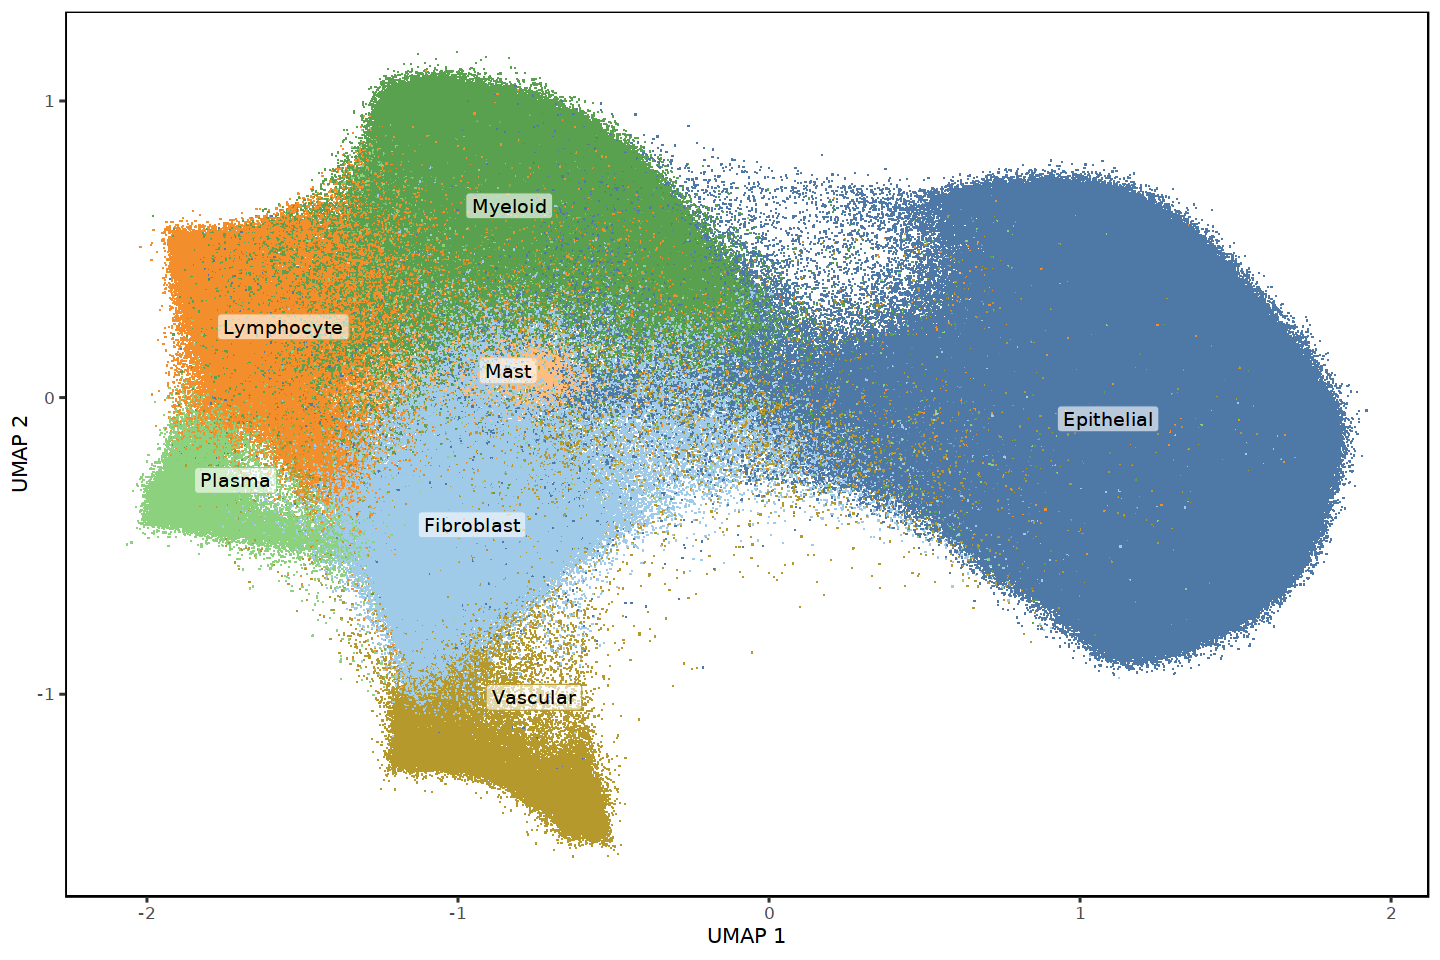

In [241]:
fig.size(8, 12)
i = which(!is.na(meta_data$type_lvl1))
# i = sample(setdiff(seq_len(nrow(meta_data)), which(is.na(meta_data$type_lvl1))), 1e5)
do_scatter(U2$embedding[i, ], meta_data[i, ], 'type_lvl1', do_labels = TRUE) 


## Markers

In [242]:
## Only using genes used for immune cell analysis 
system.time({
    markers_lvl1 <- get_markers(counts, meta_data, 'type_lvl1')    
})


CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining, by = "grpvar_orig"


   user  system elapsed 
549.503  63.289  45.577 

In [243]:
tt(markers_lvl1, fdr_max = .2, logFC_min = 0)

Warning message in tt(markers_lvl1, fdr_max = 0.2, logFC_min = 0):
“NAs introduced by coercion”


[,1]    [,2]   [,3]  [,4]     [,5]   [,6]    [,7]  [,8]   [,9]  
Epithelial KRT8    VEGFA  RNF43 MET      ETV4   LAMB3   CKB   LCN2   TM4SF1
Fibroblast COL10A1 COL1A2 SFRP2 SERPINE1 VCAN   COL3A1  MMP2  TAGLN  PDGFRB
Lymphocyte FOXP3   GNLY   ITGAE CTLA4    ZNF683 CD247   IL2RB GZMA   TRAC  
Mast       CD69    CPA3   PDCD1 MS4A2    FLI1   SIGLEC6 KIT   CA1    PSMB8 
Myeloid    SPP1    MARCO  MMP12 ITGAX    CD163  MSR1    LST1  C1QC   CSF2RA
Plasma     MZB1    CD79A  XBP1  PRDM1    CD19   ISG20   XCR1  GAS6   CD38  
Vascular   VWF     NOTCH4 GJA4  RGS5     DLL4   S1PR3   KDR   COL4A1 CSPG4 
           [,10]   
Epithelial OSMR    
Fibroblast FN1     
Lymphocyte CD2     
Mast       TNFSF13B
Myeloid    CD14    
Plasma     CD27    
Vascular   FLT1

In [244]:
## Only using genes used for immune cell analysis 
system.time({
    markers_lvl2 <- get_markers(counts, meta_data, 'type_lvl2') 
})


CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining, by = "grpvar_orig"


   user  system elapsed 
608.572  76.180  51.005 

In [245]:
tt(markers_lvl2, fdr_max = .2, logFC_min = 0)

Warning message in tt(markers_lvl2, fdr_max = 0.2, logFC_min = 0):
“NAs introduced by coercion”


[,1]     [,2]     [,3]     [,4]     [,5]    
B                            MS4A1    CD19     SELL     CCR7     S1PR1   
CD1C+ITGAX+ DC               LST1     CD1C     S100B    CSF2RA   ITGAX   
CD4 T                        CCR7     TNFRSF25 TCF7     S1PR1    SELL    
CD8 T                        LAG3     GZMA     CD8A     GZMK     EOMES   
CXCL10+ Macrophage           CXCL10   GBP1     CXCL11   IDO1     CCL8    
CXCL13+ CD4 T                CXCL13   CTLA4    CD247    RORA     TNFRSF25
CXCL13+ CD8 T                ITGAE    ZNF683   CXCL13   MKI67    GZMA    
Epithelial                   KRT8     VEGFA    RNF43    ETV4     MKI67   
FCN1+LYZ+ Macrophage         FCN1     CSF3R    LYZ      CA1      S100A8  
Fibroblast                   SERPINE1 SFRP2    COL10A1  COL1A2   COL3A1  
FLT3+ DC                     CCL17    CSF2RA   CCL22    FSCN1    FLT3    
FOLR2+CD14+ Macrophage       FOLR2    CD14     CCL13    IFNB1    C1QC    
ILC                          GNLY     ZNF683   ITGAE    IL2RB    KIR2DL4 
LAMP3+CCL19+ mreg DC         CCL22    CCL17    CCR7     FSCN1    LAMP3   
LAMP3+CD1C+ DC               LAMP3    CCL22    FSCN1    SERPINA1 BIRC3   
MARCO+ Macrophage            MARCO    MSR1     SERPINA1 CXCL16   C1QB    
Mast                         CD69     CPA3     MS4A2    FLI1     PDCD1   
MERTK+ Macrophage            IL18     CSF3R    MERTK    IL2RA    CD163   
MMP1+SOX4+ Myeloid           ALOX15B  MMP1     SOX4     CXCL8    CCL20   
NCAM1+ S100B+ SEPP1+ Myeloid NCAM1    S100B    SEPP1    B3GAT1   SPP1    
NK                           GNLY     NCAM1    ZNF683   KIR2DL4  ITGAE   
PLA2G7+ CCL18+ Macrophage    CCL18    PLA2G7   MS4A4A   CD38     GPNMB   
Plasma                       MZB1     CD79A    XBP1     CD19     PRDM1   
SPP1+ Macrophage             MMP12    SPP1     ITGAX    GPNMB    ANPEP   
TCF7+ CD8 T                  GZMK     KLRG1    EOMES    GZMA     CD3E    
Treg                         FOXP3    CTLA4    CCR8     IKZF2    TRAC    
Vascular                     VWF      DLL4     GJA4     NOTCH4   KDR     
                             [,6]   [,7]     [,8]    [,9]   [,10]  
B                            CXCR5  TCF7     CCL19   KLF2   IL7R   
CD1C+ITGAX+ DC               CSF2RB CSF3R    TNF     CCL17  CD1E   
CD4 T                        IL7R   CD40LG   CD247   KLF2   CD3E   
CD8 T                        CCL4   CCR5     CXCR6   FASLG  PRF1   
CXCL10+ Macrophage           GBP4   CXCL9    ISG15   IL1B   MX1    
CXCL13+ CD4 T                BTLA   RBPJ     STING1  CD40LG TOX    
CXCL13+ CD8 T                FASLG  TOX      GNLY    LAG3   EOMES  
Epithelial                   MET    LAMB3    EPHB4   SPRY4  OSMR   
FCN1+LYZ+ Macrophage         LST1   S100A9   IL2     CTSG   ALOX5  
Fibroblast                   PDGFRB MMP2     TAGLN   VCAN   FN1    
FLT3+ DC                     CSF2RB CD1C     LAMP3   TSLP   IL3RA  
FOLR2+CD14+ Macrophage       CSF1R  PLTP     TSLP    CD163  CCR6   
ILC                          TRDC   FASLG    GZMA    CCL5   EOMES  
LAMP3+CCL19+ mreg DC         FLT3   CSF2RA   BIRC3   CCL19  IDO1   
LAMP3+CD1C+ DC               SPP1   APOE     SOD2    NA     NA     
MARCO+ Macrophage            C1QC   C1QA     LYZ     ALOX5  ALOX5AP
Mast                         PSMB8  TNFSF13B KIT     S100A9 CA1    
MERTK+ Macrophage            MRC1   LST1     NLRP3   CSF2RA CSF1R  
MMP1+SOX4+ Myeloid           CHGB   SPP1     ACE     EPHA4  VEGFA  
NCAM1+ S100B+ SEPP1+ Myeloid CSF1   TYRO3    HBEGF   PROX1  SPRY2  
NK                           IL2RB  TRDC     SEPP1   FASLG  GZMA   
PLA2G7+ CCL18+ Macrophage    CA1    APOE     C1QB    CTSG   C1QC   
Plasma                       ISG20  GAS6     XCR1    DPEP1  SFRP2  
SPP1+ Macrophage             MSR1   MARCO    Lyve1   VEGFA  CD14   
TCF7+ CD8 T                  CD8A   CD247    CD27    TRAC   CD3G   
Treg                         IL2RB  TNFRSF1B TNFRSF4 BATF   CCR4   
Vascular                     COL4A1 S1PR3    RGS5    CSPG4  CD34

# Cache

In [ ]:
writeMM_fast(counts, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
writeLines(rownames(counts), '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
# fwrite(clusters, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/clusters.csv')
fwrite(meta_data, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
saveRDS(harmony_res$Z_corr, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/Z_corr.rds')
saveRDS(harmony_res$Z_cos, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/Z_cos.rds')
saveRDS(harmony_res$R, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/R.rds')
saveRDS(pca_res, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/pca_res.rds')
saveRDS(U, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U.rds')
saveRDS(U2, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U2.rds')


## Save these next round 
# saveRDS(harmony_res$objective_kmeans, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/objective_kmeans.rds')


fwrite(markers_lvl1, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/markers_lvl1.csv')
fwrite(markers_lvl2, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/markers_lvl2.csv')


In [ ]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell <- as.character(meta_data$cell)
counts <- readMM_fast('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
rownames(counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(counts) <- meta_data$cell
# clusters <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/clusters.csv')
U <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U.rds')
U2 <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U2.rds')

In [6]:
# Don't need these for figure or downstream analysis 
harmony_res <- list(
    Z_corr = readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/Z_corr.rds'),
    Z_cos = readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/Z_cos.rds'),
    R = readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/R.rds')
)
pca_res <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/pca_res.rds')

# Revisions: update CD4 and CD8 subtypes

In [25]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell <- as.character(meta_data$cell)
counts <- readMM_fast('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
rownames(counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(counts) <- meta_data$cell


## Update types

In [29]:
m_new = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells_immune/meta_data.csv')
m_new$cell <- as.character(m_new$cell)
i = match(m_new$cell, meta_data$cell)
meta_data$type_lvl2[i] = m_new$label

## Redo markers

In [31]:
system.time({
    i = which(meta_data$type_lvl2 != '')
    markers_lvl2 <- get_markers(counts[, i], meta_data[i, ], 'type_lvl2') 
})


CAREFUL: get_norm makes very strong assumptions about data

CAUTION: if using GLMM, make sure your counts are integers!

Joining with `by = join_by(grpvar_orig)`


   user  system elapsed 
659.561 103.317  52.789 

In [38]:
# tt(markers_lvl2, fdr_max = .2, logFC_min = 0)

In [34]:
markers_lvl2 %>% 
    filter(grepl('CD4|Treg', cluster)) %>% 
    filter(feature == 'TCF7')


cluster       feature logFC     SD        zscore    pvalue       fdr         
1 TCF7+ CD4 T   TCF7    3.6305712 0.8191561 4.4320869 4.666269e-06 0.0002562022
2 CD4 T         TCF7    2.7774281 0.9571742 2.9016955 1.855746e-03 0.0362562043
3 CXCL13+ CD4 T TCF7    0.3878965 0.7757620 0.5000200 3.085305e-01 1.0000000000
4 Treg          TCF7    0.1637860 0.9466592 0.1730148 4.313199e-01 1.0000000000

In [37]:
markers_lvl2 %>% 
    filter(feature == 'PDCD1') %>% 
    head()


cluster         feature logFC     SD        zscore   pvalue       fdr        
1 Mast            PDCD1   3.3933143 0.8583749 3.953184 3.855899e-05 0.001586433
2 CD8 T           PDCD1   1.3163793 0.3817140 3.448601 2.817491e-04 0.007827554
3 TCF7+PD1+ CD8 T PDCD1   2.1846558 0.7658917 2.852434 2.169289e-03 0.041620979
4 CXCL13+ CD4 T   PDCD1   1.5705656 0.6572268 2.389686 8.431396e-03 0.122895218
5 CXCL13+ CD8 T   PDCD1   1.9932160 0.8718263 2.286254 1.111972e-02 0.147389292
6 TCF7+ CD8 T     PDCD1   0.8374985 0.5874297 1.425700 7.697748e-02 0.564569283

## Cache

In [39]:
fwrite(meta_data, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
fwrite(markers_lvl2, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/markers_lvl2.csv')
